In [1]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/home/derin2/Desktop/Yolo/Accident/checkpoints'
trainer = Trainer(experiment_name='First_training', ckpt_root_dir=CHECKPOINT_DIR)

[2024-03-01 15:18:42] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/derin2/sg_logs/console.log


[2024-03-01 15:18:44] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-01 15:18:44] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-01 15:18:44] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-01 15:18:44] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
dataset_params = {
    'data_dir':'/home/derin2/Desktop/Yolo/YOLOv9/yolov9/AccidentsDetectionYOLOv8',  
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['moderate', 'severe']
}

In [3]:
from IPython.display import clear_output
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes'],
        'input_dim':(320,320)
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
        
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes'],
        'input_dim':(320,320)
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)


[2024-02-27 21:45:46] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|████| 10469/10469 [00:00<00:00, 12987.78it/s]
[2024-02-27 21:45:47] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████| 1004/1004 [00:00<00:00, 12471.51it/s]


In [4]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (128, 96), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (128, 96), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (128, 96), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty

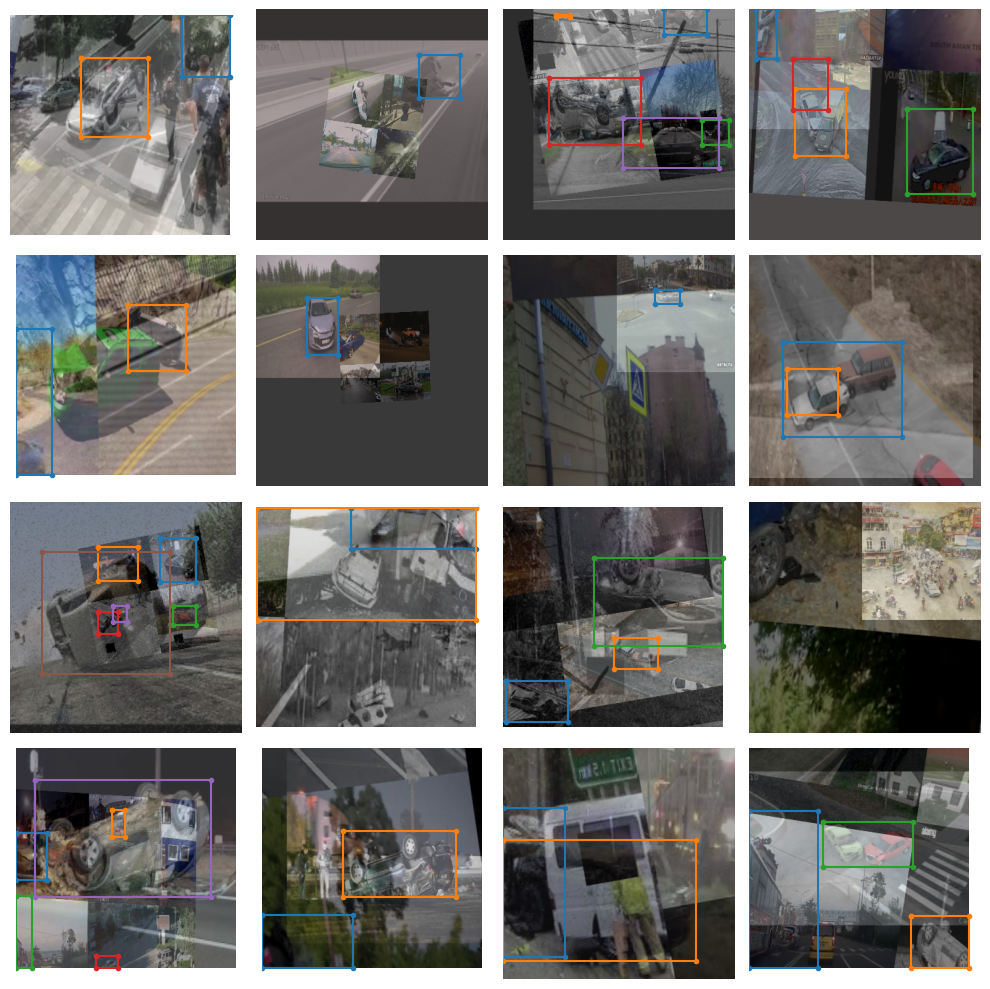

In [4]:
train_data.dataset.plot()

In [5]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050,DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=True,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95',
    "metric_to_watch": 'mAP@0.50'
}

In [6]:
from super_gradients.training import models

models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]
 
 
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )
 
    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )
 
    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2024-02-27 21:46:03] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-27 21:46:03] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
/home/derin2/miniconda3/envs/AHMED/lib/python3.10/site-packages/torch/cuda/__init__.py:193: UserWarning: 
    Found GPU2 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(


The console stream is now moved to /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/console_Şub27_21_46_12.txt


[2024-02-27 21:46:13] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-02-27 21:46:14] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (3 available on the machine)
    - Dataset size:                 10210      (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         638        (len(train_loader))
    - Gradient updates per epoch:   638        (len(train_loader) / batch_accumulate)

[2024-02-27 21:46:14] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Train epoch 0: 100%|██████████| 638/638 [02:09<00:00,  4.91it/s, PPYoloELoss/los
Validating: 100%|█████████

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2125
│   ├── Ppyoloeloss/loss_iou = 0.4404
│   ├── Ppyoloeloss/loss_dfl = 1.7919
│   └── Ppyoloeloss/loss = 4.2095
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9394
    ├── Ppyoloeloss/loss_iou = 0.2558
    ├── Ppyoloeloss/loss_dfl = 1.1845
    ├── Ppyoloeloss/loss = 3.1711
    ├── Precision@0.50 = 0.2203
    ├── Recall@0.50 = 0.3656
    ├── Map@0.50 = 0.2126
    ├── F1@0.50 = 0.2439
    ├── Precision@0.50:0.95 = 0.1447
    ├── Recall@0.50:0.95 = 0.2331
    ├── Map@0.50:0.95 = 0.1111
    └── F1@0.50:0.95 = 0.1582



Train epoch 1: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/los
Validating epoch 1: 100%|██████████| 62/62 [00:07<00:00,  8.08it/s]
[2024-02-27 21:50:55] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 21:50:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.636850118637085


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3522
│   │   ├── Epoch N-1      = 2.2125 (↘ -0.8603)
│   │   └── Best until now = 2.2125 (↘ -0.8603)
│   ├── Ppyoloeloss/loss_iou = 0.275
│   │   ├── Epoch N-1      = 0.4404 (↘ -0.1655)
│   │   └── Best until now = 0.4404 (↘ -0.1655)
│   ├── Ppyoloeloss/loss_dfl = 1.1195
│   │   ├── Epoch N-1      = 1.7919 (↘ -0.6724)
│   │   └── Best until now = 1.7919 (↘ -0.6724)
│   └── Ppyoloeloss/loss = 2.5993
│       ├── Epoch N-1      = 4.2095 (↘ -1.6102)
│       └── Best until now = 4.2095 (↘ -1.6102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1692
    │   ├── Epoch N-1      = 1.9394 (↘ -0.7702)
    │   └── Best until now = 1.9394 (↘ -0.7702)
    ├── Ppyoloeloss/loss_iou = 0.1712
    │   ├── Epoch N-1      = 0.2558 (↘ -0.0845)
    │   └── Best until now = 0.2558 (↘ -0.0845)
    ├── Ppyoloeloss/loss_dfl = 0.868
    │   ├── Epoch N-1      = 1.1845 (↘ -0.3165)
    │   └── Best until now = 1.1845 (↘ -0.3165)
    ├── Ppyoloeloss/loss

Train epoch 2: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/los
Validating epoch 2: 100%|██████████| 62/62 [00:07<00:00,  8.28it/s]
[2024-02-27 21:53:22] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 21:53:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6506876945495605


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2645
│   │   ├── Epoch N-1      = 1.3522 (↘ -0.0877)
│   │   └── Best until now = 1.3522 (↘ -0.0877)
│   ├── Ppyoloeloss/loss_iou = 0.2514
│   │   ├── Epoch N-1      = 0.275  (↘ -0.0235)
│   │   └── Best until now = 0.275  (↘ -0.0235)
│   ├── Ppyoloeloss/loss_dfl = 1.0499
│   │   ├── Epoch N-1      = 1.1195 (↘ -0.0696)
│   │   └── Best until now = 1.1195 (↘ -0.0696)
│   └── Ppyoloeloss/loss = 2.418
│       ├── Epoch N-1      = 2.5993 (↘ -0.1814)
│       └── Best until now = 2.5993 (↘ -0.1814)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0882
    │   ├── Epoch N-1      = 1.1692 (↘ -0.081)
    │   └── Best until now = 1.1692 (↘ -0.081)
    ├── Ppyoloeloss/loss_iou = 0.1683
    │   ├── Epoch N-1      = 0.1712 (↘ -0.003)
    │   └── Best until now = 0.1712 (↘ -0.003)
    ├── Ppyoloeloss/loss_dfl = 0.8499
    │   ├── Epoch N-1      = 0.868  (↘ -0.0181)
    │   └── Best until now = 0.868  (↘ -0.0181)
    ├── Ppyoloeloss/loss = 

Train epoch 3: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/los
Validating epoch 3: 100%|██████████| 62/62 [00:07<00:00,  8.24it/s]
[2024-02-27 21:55:50] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 21:55:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6855547428131104


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2449
│   │   ├── Epoch N-1      = 1.2645 (↘ -0.0196)
│   │   └── Best until now = 1.2645 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.2476
│   │   ├── Epoch N-1      = 0.2514 (↘ -0.0038)
│   │   └── Best until now = 0.2514 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 1.0368
│   │   ├── Epoch N-1      = 1.0499 (↘ -0.0131)
│   │   └── Best until now = 1.0499 (↘ -0.0131)
│   └── Ppyoloeloss/loss = 2.3823
│       ├── Epoch N-1      = 2.418  (↘ -0.0357)
│       └── Best until now = 2.418  (↘ -0.0357)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1848
    │   ├── Epoch N-1      = 1.0882 (↗ 0.0966)
    │   └── Best until now = 1.0882 (↗ 0.0966)
    ├── Ppyoloeloss/loss_iou = 0.1761
    │   ├── Epoch N-1      = 0.1683 (↗ 0.0078)
    │   └── Best until now = 0.1683 (↗ 0.0078)
    ├── Ppyoloeloss/loss_dfl = 0.8804
    │   ├── Epoch N-1      = 0.8499 (↗ 0.0305)
    │   └── Best until now = 0.8499 (↗ 0.0305)
    ├── Ppyoloeloss/loss = 2

Train epoch 4: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/los
Validating epoch 4: 100%|██████████| 62/62 [00:07<00:00,  8.36it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2095
│   │   ├── Epoch N-1      = 1.2449 (↘ -0.0354)
│   │   └── Best until now = 1.2449 (↘ -0.0354)
│   ├── Ppyoloeloss/loss_iou = 0.2383
│   │   ├── Epoch N-1      = 0.2476 (↘ -0.0093)
│   │   └── Best until now = 0.2476 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_dfl = 1.0118
│   │   ├── Epoch N-1      = 1.0368 (↘ -0.025)
│   │   └── Best until now = 1.0368 (↘ -0.025)
│   └── Ppyoloeloss/loss = 2.3112
│       ├── Epoch N-1      = 2.3823 (↘ -0.071)
│       └── Best until now = 2.3823 (↘ -0.071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1938
    │   ├── Epoch N-1      = 1.1848 (↗ 0.009)
    │   └── Best until now = 1.0882 (↗ 0.1056)
    ├── Ppyoloeloss/loss_iou = 0.1757
    │   ├── Epoch N-1      = 0.1761 (↘ -0.0004)
    │   └── Best until now = 0.1683 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.8785
    │   ├── Epoch N-1      = 0.8804 (↘ -0.0019)
    │   └── Best until now = 0.8499 (↗ 0.0285)
    ├── Ppyoloeloss/loss = 2.07

Train epoch 5: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/los
Validating epoch 5: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s]
[2024-02-27 22:00:48] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:00:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6984366774559021


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1942
│   │   ├── Epoch N-1      = 1.2095 (↘ -0.0153)
│   │   └── Best until now = 1.2095 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.2336
│   │   ├── Epoch N-1      = 0.2383 (↘ -0.0047)
│   │   └── Best until now = 0.2383 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_dfl = 1.0015
│   │   ├── Epoch N-1      = 1.0118 (↘ -0.0103)
│   │   └── Best until now = 1.0118 (↘ -0.0103)
│   └── Ppyoloeloss/loss = 2.279
│       ├── Epoch N-1      = 2.3112 (↘ -0.0323)
│       └── Best until now = 2.3112 (↘ -0.0323)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.062
    │   ├── Epoch N-1      = 1.1938 (↘ -0.1318)
    │   └── Best until now = 1.0882 (↘ -0.0262)
    ├── Ppyoloeloss/loss_iou = 0.1716
    │   ├── Epoch N-1      = 0.1757 (↘ -0.0041)
    │   └── Best until now = 0.1683 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.8667
    │   ├── Epoch N-1      = 0.8785 (↘ -0.0118)
    │   └── Best until now = 0.8499 (↗ 0.0168)
    ├── Ppyoloeloss/loss =

Train epoch 6: 100%|██████████| 638/638 [02:10<00:00,  4.90it/s, PPYoloELoss/los
Validating epoch 6: 100%|██████████| 62/62 [00:07<00:00,  8.38it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1797
│   │   ├── Epoch N-1      = 1.1942 (↘ -0.0145)
│   │   └── Best until now = 1.1942 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.2293
│   │   ├── Epoch N-1      = 0.2336 (↘ -0.0043)
│   │   └── Best until now = 0.2336 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.9896
│   │   ├── Epoch N-1      = 1.0015 (↘ -0.0118)
│   │   └── Best until now = 1.0015 (↘ -0.0118)
│   └── Ppyoloeloss/loss = 2.2478
│       ├── Epoch N-1      = 2.279  (↘ -0.0312)
│       └── Best until now = 2.279  (↘ -0.0312)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3257
    │   ├── Epoch N-1      = 1.062  (↗ 0.2637)
    │   └── Best until now = 1.062  (↗ 0.2637)
    ├── Ppyoloeloss/loss_iou = 0.1892
    │   ├── Epoch N-1      = 0.1716 (↗ 0.0176)
    │   └── Best until now = 0.1683 (↗ 0.021)
    ├── Ppyoloeloss/loss_dfl = 0.9456
    │   ├── Epoch N-1      = 0.8667 (↗ 0.0789)
    │   └── Best until now = 0.8499 (↗ 0.0957)
    ├── Ppyoloeloss/loss = 2.

Train epoch 7: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/los
Validating epoch 7: 100%|██████████| 62/62 [00:07<00:00,  8.19it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1623
│   │   ├── Epoch N-1      = 1.1797 (↘ -0.0174)
│   │   └── Best until now = 1.1797 (↘ -0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.2274
│   │   ├── Epoch N-1      = 0.2293 (↘ -0.0019)
│   │   └── Best until now = 0.2293 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.9816
│   │   ├── Epoch N-1      = 0.9896 (↘ -0.008)
│   │   └── Best until now = 0.9896 (↘ -0.008)
│   └── Ppyoloeloss/loss = 2.2216
│       ├── Epoch N-1      = 2.2478 (↘ -0.0262)
│       └── Best until now = 2.2478 (↘ -0.0262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1383
    │   ├── Epoch N-1      = 1.3257 (↘ -0.1873)
    │   └── Best until now = 1.062  (↗ 0.0763)
    ├── Ppyoloeloss/loss_iou = 0.1682
    │   ├── Epoch N-1      = 0.1892 (↘ -0.021)
    │   └── Best until now = 0.1683 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.8502
    │   ├── Epoch N-1      = 0.9456 (↘ -0.0954)
    │   └── Best until now = 0.8499 (↗ 0.0002)
    ├── Ppyoloeloss/loss = 1

Train epoch 8: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/los
Validating epoch 8: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s]
[2024-02-27 22:08:19] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:08:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7141821980476379


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1532
│   │   ├── Epoch N-1      = 1.1623 (↘ -0.0092)
│   │   └── Best until now = 1.1623 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.2243
│   │   ├── Epoch N-1      = 0.2274 (↘ -0.0031)
│   │   └── Best until now = 0.2274 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.9774
│   │   ├── Epoch N-1      = 0.9816 (↘ -0.0042)
│   │   └── Best until now = 0.9816 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 2.2026
│       ├── Epoch N-1      = 2.2216 (↘ -0.019)
│       └── Best until now = 2.2216 (↘ -0.019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0369
    │   ├── Epoch N-1      = 1.1383 (↘ -0.1014)
    │   └── Best until now = 1.062  (↘ -0.0251)
    ├── Ppyoloeloss/loss_iou = 0.1586
    │   ├── Epoch N-1      = 0.1682 (↘ -0.0096)
    │   └── Best until now = 0.1682 (↘ -0.0096)
    ├── Ppyoloeloss/loss_dfl = 0.8268
    │   ├── Epoch N-1      = 0.8502 (↘ -0.0234)
    │   └── Best until now = 0.8499 (↘ -0.0232)
    ├── Ppyoloeloss/loss

Train epoch 9: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/los
Validating epoch 9: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1385
│   │   ├── Epoch N-1      = 1.1532 (↘ -0.0147)
│   │   └── Best until now = 1.1532 (↘ -0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.2209
│   │   ├── Epoch N-1      = 0.2243 (↘ -0.0034)
│   │   └── Best until now = 0.2243 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.9659
│   │   ├── Epoch N-1      = 0.9774 (↘ -0.0114)
│   │   └── Best until now = 0.9774 (↘ -0.0114)
│   └── Ppyoloeloss/loss = 2.1737
│       ├── Epoch N-1      = 2.2026 (↘ -0.0289)
│       └── Best until now = 2.2026 (↘ -0.0289)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0903
    │   ├── Epoch N-1      = 1.0369 (↗ 0.0534)
    │   └── Best until now = 1.0369 (↗ 0.0534)
    ├── Ppyoloeloss/loss_iou = 0.169
    │   ├── Epoch N-1      = 0.1586 (↗ 0.0104)
    │   └── Best until now = 0.1586 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.8598
    │   ├── Epoch N-1      = 0.8268 (↗ 0.033)
    │   └── Best until now = 0.8268 (↗ 0.033)
    ├── Ppyoloeloss/loss = 1.94

Train epoch 10: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 10: 100%|██████████| 62/62 [00:07<00:00,  8.28it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1332
│   │   ├── Epoch N-1      = 1.1385 (↘ -0.0053)
│   │   └── Best until now = 1.1385 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.2182
│   │   ├── Epoch N-1      = 0.2209 (↘ -0.0027)
│   │   └── Best until now = 0.2209 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.9617
│   │   ├── Epoch N-1      = 0.9659 (↘ -0.0042)
│   │   └── Best until now = 0.9659 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 2.1597
│       ├── Epoch N-1      = 2.1737 (↘ -0.014)
│       └── Best until now = 2.1737 (↘ -0.014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0998
    │   ├── Epoch N-1      = 1.0903 (↗ 0.0094)
    │   └── Best until now = 1.0369 (↗ 0.0629)
    ├── Ppyoloeloss/loss_iou = 0.1618
    │   ├── Epoch N-1      = 0.169  (↘ -0.0072)
    │   └── Best until now = 0.1586 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.8392
    │   ├── Epoch N-1      = 0.8598 (↘ -0.0206)
    │   └── Best until now = 0.8268 (↗ 0.0124)
    ├── Ppyoloeloss/loss = 

Train epoch 11: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 11: 100%|██████████| 62/62 [00:07<00:00,  8.27it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.121
│   │   ├── Epoch N-1      = 1.1332 (↘ -0.0122)
│   │   └── Best until now = 1.1332 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.2164
│   │   ├── Epoch N-1      = 0.2182 (↘ -0.0019)
│   │   └── Best until now = 0.2182 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.9537
│   │   ├── Epoch N-1      = 0.9617 (↘ -0.008)
│   │   └── Best until now = 0.9617 (↘ -0.008)
│   └── Ppyoloeloss/loss = 2.1388
│       ├── Epoch N-1      = 2.1597 (↘ -0.0209)
│       └── Best until now = 2.1597 (↘ -0.0209)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1766
    │   ├── Epoch N-1      = 1.0998 (↗ 0.0768)
    │   └── Best until now = 1.0369 (↗ 0.1396)
    ├── Ppyoloeloss/loss_iou = 0.1727
    │   ├── Epoch N-1      = 0.1618 (↗ 0.0109)
    │   └── Best until now = 0.1586 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.8822
    │   ├── Epoch N-1      = 0.8392 (↗ 0.0431)
    │   └── Best until now = 0.8268 (↗ 0.0554)
    ├── Ppyoloeloss/loss = 2.0

Train epoch 12: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 12: 100%|██████████| 62/62 [00:07<00:00,  8.29it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1037
│   │   ├── Epoch N-1      = 1.121  (↘ -0.0173)
│   │   └── Best until now = 1.121  (↘ -0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.212
│   │   ├── Epoch N-1      = 0.2164 (↘ -0.0044)
│   │   └── Best until now = 0.2164 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.9427
│   │   ├── Epoch N-1      = 0.9537 (↘ -0.011)
│   │   └── Best until now = 0.9537 (↘ -0.011)
│   └── Ppyoloeloss/loss = 2.105
│       ├── Epoch N-1      = 2.1388 (↘ -0.0339)
│       └── Best until now = 2.1388 (↘ -0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.101
    │   ├── Epoch N-1      = 1.1766 (↘ -0.0755)
    │   └── Best until now = 1.0369 (↗ 0.0641)
    ├── Ppyoloeloss/loss_iou = 0.1687
    │   ├── Epoch N-1      = 0.1727 (↘ -0.0041)
    │   └── Best until now = 0.1586 (↗ 0.0101)
    ├── Ppyoloeloss/loss_dfl = 0.8707
    │   ├── Epoch N-1      = 0.8822 (↘ -0.0115)
    │   └── Best until now = 0.8268 (↗ 0.0439)
    ├── Ppyoloeloss/loss = 1.

Train epoch 13: 100%|██████████| 638/638 [02:10<00:00,  4.89it/s, PPYoloELoss/lo
Validating epoch 13: 100%|██████████| 62/62 [00:07<00:00,  8.21it/s]
[2024-02-27 22:21:04] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:21:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7327989935874939


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0978
│   │   ├── Epoch N-1      = 1.1037 (↘ -0.0059)
│   │   └── Best until now = 1.1037 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.21
│   │   ├── Epoch N-1      = 0.212  (↘ -0.002)
│   │   └── Best until now = 0.212  (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.9377
│   │   ├── Epoch N-1      = 0.9427 (↘ -0.005)
│   │   └── Best until now = 0.9427 (↘ -0.005)
│   └── Ppyoloeloss/loss = 2.0917
│       ├── Epoch N-1      = 2.105  (↘ -0.0133)
│       └── Best until now = 2.105  (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0051
    │   ├── Epoch N-1      = 1.101  (↘ -0.096)
    │   └── Best until now = 1.0369 (↘ -0.0319)
    ├── Ppyoloeloss/loss_iou = 0.1555
    │   ├── Epoch N-1      = 0.1687 (↘ -0.0132)
    │   └── Best until now = 0.1586 (↘ -0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.8292
    │   ├── Epoch N-1      = 0.8707 (↘ -0.0415)
    │   └── Best until now = 0.8268 (↗ 0.0024)
    ├── Ppyoloeloss/loss = 1.

Train epoch 14: 100%|██████████| 638/638 [02:09<00:00,  4.92it/s, PPYoloELoss/lo
Validating epoch 14: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0829
│   │   ├── Epoch N-1      = 1.0978 (↘ -0.015)
│   │   └── Best until now = 1.0978 (↘ -0.015)
│   ├── Ppyoloeloss/loss_iou = 0.2058
│   │   ├── Epoch N-1      = 0.21   (↘ -0.0042)
│   │   └── Best until now = 0.21   (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.9286
│   │   ├── Epoch N-1      = 0.9377 (↘ -0.0091)
│   │   └── Best until now = 0.9377 (↘ -0.0091)
│   └── Ppyoloeloss/loss = 2.0617
│       ├── Epoch N-1      = 2.0917 (↘ -0.03)
│       └── Best until now = 2.0917 (↘ -0.03)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.167
    │   ├── Epoch N-1      = 1.0051 (↗ 0.162)
    │   └── Best until now = 1.0051 (↗ 0.162)
    ├── Ppyoloeloss/loss_iou = 0.1666
    │   ├── Epoch N-1      = 0.1555 (↗ 0.0111)
    │   └── Best until now = 0.1555 (↗ 0.0111)
    ├── Ppyoloeloss/loss_dfl = 0.849
    │   ├── Epoch N-1      = 0.8292 (↗ 0.0198)
    │   └── Best until now = 0.8268 (↗ 0.0222)
    ├── Ppyoloeloss/loss = 2.0081
   

Train epoch 15: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 15: 100%|██████████| 62/62 [00:07<00:00,  8.39it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0686
│   │   ├── Epoch N-1      = 1.0829 (↘ -0.0142)
│   │   └── Best until now = 1.0829 (↘ -0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.2023
│   │   ├── Epoch N-1      = 0.2058 (↘ -0.0036)
│   │   └── Best until now = 0.2058 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.9192
│   │   ├── Epoch N-1      = 0.9286 (↘ -0.0094)
│   │   └── Best until now = 0.9286 (↘ -0.0094)
│   └── Ppyoloeloss/loss = 2.0339
│       ├── Epoch N-1      = 2.0617 (↘ -0.0278)
│       └── Best until now = 2.0617 (↘ -0.0278)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0496
    │   ├── Epoch N-1      = 1.167  (↘ -0.1174)
    │   └── Best until now = 1.0051 (↗ 0.0446)
    ├── Ppyoloeloss/loss_iou = 0.1618
    │   ├── Epoch N-1      = 0.1666 (↘ -0.0048)
    │   └── Best until now = 0.1555 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.8563
    │   ├── Epoch N-1      = 0.849  (↗ 0.0073)
    │   └── Best until now = 0.8268 (↗ 0.0295)
    ├── Ppyoloeloss/loss 

Train epoch 16: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 16: 100%|██████████| 62/62 [00:07<00:00,  8.40it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0499
│   │   ├── Epoch N-1      = 1.0686 (↘ -0.0188)
│   │   └── Best until now = 1.0686 (↘ -0.0188)
│   ├── Ppyoloeloss/loss_iou = 0.199
│   │   ├── Epoch N-1      = 0.2023 (↘ -0.0032)
│   │   └── Best until now = 0.2023 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.9105
│   │   ├── Epoch N-1      = 0.9192 (↘ -0.0087)
│   │   └── Best until now = 0.9192 (↘ -0.0087)
│   └── Ppyoloeloss/loss = 2.0027
│       ├── Epoch N-1      = 2.0339 (↘ -0.0312)
│       └── Best until now = 2.0339 (↘ -0.0312)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1344
    │   ├── Epoch N-1      = 1.0496 (↗ 0.0848)
    │   └── Best until now = 1.0051 (↗ 0.1294)
    ├── Ppyoloeloss/loss_iou = 0.1561
    │   ├── Epoch N-1      = 0.1618 (↘ -0.0057)
    │   └── Best until now = 0.1555 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.8404
    │   ├── Epoch N-1      = 0.8563 (↘ -0.0159)
    │   └── Best until now = 0.8268 (↗ 0.0136)
    ├── Ppyoloeloss/loss =

Train epoch 17: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 17: 100%|██████████| 62/62 [00:07<00:00,  8.30it/s]
[2024-02-27 22:31:19] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:31:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7393794059753418


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0422
│   │   ├── Epoch N-1      = 1.0499 (↘ -0.0076)
│   │   └── Best until now = 1.0499 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.1973
│   │   ├── Epoch N-1      = 0.199  (↘ -0.0017)
│   │   └── Best until now = 0.199  (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.9068
│   │   ├── Epoch N-1      = 0.9105 (↘ -0.0036)
│   │   └── Best until now = 0.9105 (↘ -0.0036)
│   └── Ppyoloeloss/loss = 1.9889
│       ├── Epoch N-1      = 2.0027 (↘ -0.0138)
│       └── Best until now = 2.0027 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0677
    │   ├── Epoch N-1      = 1.1344 (↘ -0.0667)
    │   └── Best until now = 1.0051 (↗ 0.0626)
    ├── Ppyoloeloss/loss_iou = 0.149
    │   ├── Epoch N-1      = 0.1561 (↘ -0.0071)
    │   └── Best until now = 0.1555 (↘ -0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.8099
    │   ├── Epoch N-1      = 0.8404 (↘ -0.0304)
    │   └── Best until now = 0.8268 (↘ -0.0168)
    ├── Ppyoloeloss/los

Train epoch 18: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 18: 100%|██████████| 62/62 [00:07<00:00,  8.38it/s]
[2024-02-27 22:33:54] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:33:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7769598960876465


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0269
│   │   ├── Epoch N-1      = 1.0422 (↘ -0.0153)
│   │   └── Best until now = 1.0422 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.1942
│   │   ├── Epoch N-1      = 0.1973 (↘ -0.0032)
│   │   └── Best until now = 0.1973 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.8993
│   │   ├── Epoch N-1      = 0.9068 (↘ -0.0075)
│   │   └── Best until now = 0.9068 (↘ -0.0075)
│   └── Ppyoloeloss/loss = 1.9619
│       ├── Epoch N-1      = 1.9889 (↘ -0.027)
│       └── Best until now = 1.9889 (↘ -0.027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9929
    │   ├── Epoch N-1      = 1.0677 (↘ -0.0747)
    │   └── Best until now = 1.0051 (↘ -0.0121)
    ├── Ppyoloeloss/loss_iou = 0.1501
    │   ├── Epoch N-1      = 0.149  (↗ 0.0011)
    │   └── Best until now = 0.149  (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.8164
    │   ├── Epoch N-1      = 0.8099 (↗ 0.0065)
    │   └── Best until now = 0.8099 (↗ 0.0065)
    ├── Ppyoloeloss/loss = 

Train epoch 19: 100%|██████████| 638/638 [02:09<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 19: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.02
│   │   ├── Epoch N-1      = 1.0269 (↘ -0.0069)
│   │   └── Best until now = 1.0269 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.1926
│   │   ├── Epoch N-1      = 0.1942 (↘ -0.0015)
│   │   └── Best until now = 0.1942 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.8937
│   │   ├── Epoch N-1      = 0.8993 (↘ -0.0056)
│   │   └── Best until now = 0.8993 (↘ -0.0056)
│   └── Ppyoloeloss/loss = 1.9484
│       ├── Epoch N-1      = 1.9619 (↘ -0.0135)
│       └── Best until now = 1.9619 (↘ -0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0183
    │   ├── Epoch N-1      = 0.9929 (↗ 0.0253)
    │   └── Best until now = 0.9929 (↗ 0.0253)
    ├── Ppyoloeloss/loss_iou = 0.1421
    │   ├── Epoch N-1      = 0.1501 (↘ -0.0081)
    │   └── Best until now = 0.149  (↘ -0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.7975
    │   ├── Epoch N-1      = 0.8164 (↘ -0.0189)
    │   └── Best until now = 0.8099 (↘ -0.0125)
    ├── Ppyoloeloss/loss 

Train epoch 20: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 20: 100%|██████████| 62/62 [00:07<00:00,  8.48it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0024
│   │   ├── Epoch N-1      = 1.02   (↘ -0.0176)
│   │   └── Best until now = 1.02   (↘ -0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.1882
│   │   ├── Epoch N-1      = 0.1926 (↘ -0.0044)
│   │   └── Best until now = 0.1926 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.8828
│   │   ├── Epoch N-1      = 0.8937 (↘ -0.0109)
│   │   └── Best until now = 0.8937 (↘ -0.0109)
│   └── Ppyoloeloss/loss = 1.9143
│       ├── Epoch N-1      = 1.9484 (↘ -0.0341)
│       └── Best until now = 1.9484 (↘ -0.0341)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.039
    │   ├── Epoch N-1      = 1.0183 (↗ 0.0207)
    │   └── Best until now = 0.9929 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.1376
    │   ├── Epoch N-1      = 0.1421 (↘ -0.0044)
    │   └── Best until now = 0.1421 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.78
    │   ├── Epoch N-1      = 0.7975 (↘ -0.0175)
    │   └── Best until now = 0.7975 (↘ -0.0175)
    ├── Ppyoloeloss/loss = 

Train epoch 21: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 21: 100%|██████████| 62/62 [00:07<00:00,  8.46it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.996
│   │   ├── Epoch N-1      = 1.0024 (↘ -0.0064)
│   │   └── Best until now = 1.0024 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.186
│   │   ├── Epoch N-1      = 0.1882 (↘ -0.0022)
│   │   └── Best until now = 0.1882 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.8786
│   │   ├── Epoch N-1      = 0.8828 (↘ -0.0042)
│   │   └── Best until now = 0.8828 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.9004
│       ├── Epoch N-1      = 1.9143 (↘ -0.0139)
│       └── Best until now = 1.9143 (↘ -0.0139)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9911
    │   ├── Epoch N-1      = 1.039  (↘ -0.0479)
    │   └── Best until now = 0.9929 (↘ -0.0019)
    ├── Ppyoloeloss/loss_iou = 0.147
    │   ├── Epoch N-1      = 0.1376 (↗ 0.0093)
    │   └── Best until now = 0.1376 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.8223
    │   ├── Epoch N-1      = 0.78   (↗ 0.0423)
    │   └── Best until now = 0.78   (↗ 0.0423)
    ├── Ppyoloeloss/loss = 1

Train epoch 22: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 22: 100%|██████████| 62/62 [00:07<00:00,  8.43it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9811
│   │   ├── Epoch N-1      = 0.996  (↘ -0.0148)
│   │   └── Best until now = 0.996  (↘ -0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.1834
│   │   ├── Epoch N-1      = 0.186  (↘ -0.0026)
│   │   └── Best until now = 0.186  (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.8725
│   │   ├── Epoch N-1      = 0.8786 (↘ -0.0061)
│   │   └── Best until now = 0.8786 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.8759
│       ├── Epoch N-1      = 1.9004 (↘ -0.0245)
│       └── Best until now = 1.9004 (↘ -0.0245)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0487
    │   ├── Epoch N-1      = 0.9911 (↗ 0.0577)
    │   └── Best until now = 0.9911 (↗ 0.0577)
    ├── Ppyoloeloss/loss_iou = 0.1509
    │   ├── Epoch N-1      = 0.147  (↗ 0.004)
    │   └── Best until now = 0.1376 (↗ 0.0133)
    ├── Ppyoloeloss/loss_dfl = 0.8523
    │   ├── Epoch N-1      = 0.8223 (↗ 0.03)
    │   └── Best until now = 0.78   (↗ 0.0723)
    ├── Ppyoloeloss/loss = 1.8

Train epoch 23: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 23: 100%|██████████| 62/62 [00:07<00:00,  8.38it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9662
│   │   ├── Epoch N-1      = 0.9811 (↘ -0.015)
│   │   └── Best until now = 0.9811 (↘ -0.015)
│   ├── Ppyoloeloss/loss_iou = 0.1802
│   │   ├── Epoch N-1      = 0.1834 (↘ -0.0032)
│   │   └── Best until now = 0.1834 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.8664
│   │   ├── Epoch N-1      = 0.8725 (↘ -0.0062)
│   │   └── Best until now = 0.8725 (↘ -0.0062)
│   └── Ppyoloeloss/loss = 1.8499
│       ├── Epoch N-1      = 1.8759 (↘ -0.026)
│       └── Best until now = 1.8759 (↘ -0.026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0101
    │   ├── Epoch N-1      = 1.0487 (↘ -0.0386)
    │   └── Best until now = 0.9911 (↗ 0.019)
    ├── Ppyoloeloss/loss_iou = 0.1501
    │   ├── Epoch N-1      = 0.1509 (↘ -0.0008)
    │   └── Best until now = 0.1376 (↗ 0.0125)
    ├── Ppyoloeloss/loss_dfl = 0.8175
    │   ├── Epoch N-1      = 0.8523 (↘ -0.0348)
    │   └── Best until now = 0.78   (↗ 0.0375)
    ├── Ppyoloeloss/loss = 1.

Train epoch 24: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 24: 100%|██████████| 62/62 [00:07<00:00,  8.35it/s]
[2024-02-27 22:49:12] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:49:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.778954267501831


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9542
│   │   ├── Epoch N-1      = 0.9662 (↘ -0.0119)
│   │   └── Best until now = 0.9662 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.1767
│   │   ├── Epoch N-1      = 0.1802 (↘ -0.0035)
│   │   └── Best until now = 0.1802 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.8577
│   │   ├── Epoch N-1      = 0.8664 (↘ -0.0087)
│   │   └── Best until now = 0.8664 (↘ -0.0087)
│   └── Ppyoloeloss/loss = 1.8249
│       ├── Epoch N-1      = 1.8499 (↘ -0.0251)
│       └── Best until now = 1.8499 (↘ -0.0251)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0245
    │   ├── Epoch N-1      = 1.0101 (↗ 0.0144)
    │   └── Best until now = 0.9911 (↗ 0.0334)
    ├── Ppyoloeloss/loss_iou = 0.1359
    │   ├── Epoch N-1      = 0.1501 (↘ -0.0143)
    │   └── Best until now = 0.1376 (↘ -0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.7789
    │   ├── Epoch N-1      = 0.8175 (↘ -0.0386)
    │   └── Best until now = 0.78   (↘ -0.0011)
    ├── Ppyoloeloss/los

Train epoch 25: 100%|██████████| 638/638 [02:10<00:00,  4.90it/s, PPYoloELoss/lo
Validating epoch 25: 100%|██████████| 62/62 [00:07<00:00,  8.35it/s]
[2024-02-27 22:51:49] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:51:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7878146767616272


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9465
│   │   ├── Epoch N-1      = 0.9542 (↘ -0.0077)
│   │   └── Best until now = 0.9542 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.1735
│   │   ├── Epoch N-1      = 0.1767 (↘ -0.0032)
│   │   └── Best until now = 0.1767 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.8506
│   │   ├── Epoch N-1      = 0.8577 (↘ -0.0071)
│   │   └── Best until now = 0.8577 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 1.8055
│       ├── Epoch N-1      = 1.8249 (↘ -0.0194)
│       └── Best until now = 1.8249 (↘ -0.0194)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9047
    │   ├── Epoch N-1      = 1.0245 (↘ -0.1198)
    │   └── Best until now = 0.9911 (↘ -0.0863)
    ├── Ppyoloeloss/loss_iou = 0.1367
    │   ├── Epoch N-1      = 0.1359 (↗ 0.0009)
    │   └── Best until now = 0.1359 (↗ 0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.7852
    │   ├── Epoch N-1      = 0.7789 (↗ 0.0063)
    │   └── Best until now = 0.7789 (↗ 0.0063)
    ├── Ppyoloeloss/loss 

Train epoch 26: 100%|██████████| 638/638 [02:10<00:00,  4.89it/s, PPYoloELoss/lo
Validating epoch 26: 100%|██████████| 62/62 [00:07<00:00,  8.16it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9317
│   │   ├── Epoch N-1      = 0.9465 (↘ -0.0148)
│   │   └── Best until now = 0.9465 (↘ -0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.1718
│   │   ├── Epoch N-1      = 0.1735 (↘ -0.0017)
│   │   └── Best until now = 0.1735 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.8454
│   │   ├── Epoch N-1      = 0.8506 (↘ -0.0052)
│   │   └── Best until now = 0.8506 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.7839
│       ├── Epoch N-1      = 1.8055 (↘ -0.0216)
│       └── Best until now = 1.8055 (↘ -0.0216)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9919
    │   ├── Epoch N-1      = 0.9047 (↗ 0.0871)
    │   └── Best until now = 0.9047 (↗ 0.0871)
    ├── Ppyoloeloss/loss_iou = 0.1382
    │   ├── Epoch N-1      = 0.1367 (↗ 0.0015)
    │   └── Best until now = 0.1359 (↗ 0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.7972
    │   ├── Epoch N-1      = 0.7852 (↗ 0.012)
    │   └── Best until now = 0.7789 (↗ 0.0183)
    ├── Ppyoloeloss/loss = 1

Train epoch 27: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 27: 100%|██████████| 62/62 [00:07<00:00,  8.56it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9236
│   │   ├── Epoch N-1      = 0.9317 (↘ -0.0081)
│   │   └── Best until now = 0.9317 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_iou = 0.1699
│   │   ├── Epoch N-1      = 0.1718 (↘ -0.002)
│   │   └── Best until now = 0.1718 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.8448
│   │   ├── Epoch N-1      = 0.8454 (↘ -0.0006)
│   │   └── Best until now = 0.8454 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.7706
│       ├── Epoch N-1      = 1.7839 (↘ -0.0133)
│       └── Best until now = 1.7839 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9974
    │   ├── Epoch N-1      = 0.9919 (↗ 0.0055)
    │   └── Best until now = 0.9047 (↗ 0.0926)
    ├── Ppyoloeloss/loss_iou = 0.1323
    │   ├── Epoch N-1      = 0.1382 (↘ -0.0059)
    │   └── Best until now = 0.1359 (↘ -0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.7724
    │   ├── Epoch N-1      = 0.7972 (↘ -0.0248)
    │   └── Best until now = 0.7789 (↘ -0.0065)
    ├── Ppyoloeloss/loss 

Train epoch 28: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 28: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s]
[2024-02-27 22:59:30] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 22:59:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8184142112731934


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9078
│   │   ├── Epoch N-1      = 0.9236 (↘ -0.0159)
│   │   └── Best until now = 0.9236 (↘ -0.0159)
│   ├── Ppyoloeloss/loss_iou = 0.1673
│   │   ├── Epoch N-1      = 0.1699 (↘ -0.0025)
│   │   └── Best until now = 0.1699 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.8353
│   │   ├── Epoch N-1      = 0.8448 (↘ -0.0094)
│   │   └── Best until now = 0.8448 (↘ -0.0094)
│   └── Ppyoloeloss/loss = 1.7437
│       ├── Epoch N-1      = 1.7706 (↘ -0.0269)
│       └── Best until now = 1.7706 (↘ -0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9415
    │   ├── Epoch N-1      = 0.9974 (↘ -0.0559)
    │   └── Best until now = 0.9047 (↗ 0.0367)
    ├── Ppyoloeloss/loss_iou = 0.1317
    │   ├── Epoch N-1      = 0.1323 (↘ -0.0006)
    │   └── Best until now = 0.1323 (↘ -0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.7731
    │   ├── Epoch N-1      = 0.7724 (↗ 0.0007)
    │   └── Best until now = 0.7724 (↗ 0.0007)
    ├── Ppyoloeloss/loss

Train epoch 29: 100%|██████████| 638/638 [02:09<00:00,  4.92it/s, PPYoloELoss/lo
Validating epoch 29: 100%|██████████| 62/62 [00:07<00:00,  8.39it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8908
│   │   ├── Epoch N-1      = 0.9078 (↘ -0.017)
│   │   └── Best until now = 0.9078 (↘ -0.017)
│   ├── Ppyoloeloss/loss_iou = 0.1638
│   │   ├── Epoch N-1      = 0.1673 (↘ -0.0036)
│   │   └── Best until now = 0.1673 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.8289
│   │   ├── Epoch N-1      = 0.8353 (↘ -0.0064)
│   │   └── Best until now = 0.8353 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.7147
│       ├── Epoch N-1      = 1.7437 (↘ -0.0291)
│       └── Best until now = 1.7437 (↘ -0.0291)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0789
    │   ├── Epoch N-1      = 0.9415 (↗ 0.1375)
    │   └── Best until now = 0.9047 (↗ 0.1742)
    ├── Ppyoloeloss/loss_iou = 0.1389
    │   ├── Epoch N-1      = 0.1317 (↗ 0.0073)
    │   └── Best until now = 0.1317 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.7898
    │   ├── Epoch N-1      = 0.7731 (↗ 0.0167)
    │   └── Best until now = 0.7724 (↗ 0.0174)
    ├── Ppyoloeloss/loss = 1.

Train epoch 30: 100%|██████████| 638/638 [02:09<00:00,  4.91it/s, PPYoloELoss/lo
Validating epoch 30: 100%|██████████| 62/62 [00:07<00:00,  8.30it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8866
│   │   ├── Epoch N-1      = 0.8908 (↘ -0.0042)
│   │   └── Best until now = 0.8908 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.1617
│   │   ├── Epoch N-1      = 0.1638 (↘ -0.002)
│   │   └── Best until now = 0.1638 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.8231
│   │   ├── Epoch N-1      = 0.8289 (↘ -0.0059)
│   │   └── Best until now = 0.8289 (↘ -0.0059)
│   └── Ppyoloeloss/loss = 1.7024
│       ├── Epoch N-1      = 1.7147 (↘ -0.0123)
│       └── Best until now = 1.7147 (↘ -0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9016
    │   ├── Epoch N-1      = 1.0789 (↘ -0.1774)
    │   └── Best until now = 0.9047 (↘ -0.0032)
    ├── Ppyoloeloss/loss_iou = 0.1325
    │   ├── Epoch N-1      = 0.1389 (↘ -0.0065)
    │   └── Best until now = 0.1317 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.7709
    │   ├── Epoch N-1      = 0.7898 (↘ -0.0189)
    │   └── Best until now = 0.7724 (↘ -0.0015)
    ├── Ppyoloeloss/loss

Train epoch 31: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 31: 100%|██████████| 62/62 [00:07<00:00,  8.49it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8774
│   │   ├── Epoch N-1      = 0.8866 (↘ -0.0092)
│   │   └── Best until now = 0.8866 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.161
│   │   ├── Epoch N-1      = 0.1617 (↘ -0.0007)
│   │   └── Best until now = 0.1617 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.8194
│   │   ├── Epoch N-1      = 0.8231 (↘ -0.0036)
│   │   └── Best until now = 0.8231 (↘ -0.0036)
│   └── Ppyoloeloss/loss = 1.6896
│       ├── Epoch N-1      = 1.7024 (↘ -0.0128)
│       └── Best until now = 1.7024 (↘ -0.0128)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9338
    │   ├── Epoch N-1      = 0.9016 (↗ 0.0322)
    │   └── Best until now = 0.9016 (↗ 0.0322)
    ├── Ppyoloeloss/loss_iou = 0.1364
    │   ├── Epoch N-1      = 0.1325 (↗ 0.0039)
    │   └── Best until now = 0.1317 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 0.7853
    │   ├── Epoch N-1      = 0.7709 (↗ 0.0144)
    │   └── Best until now = 0.7709 (↗ 0.0144)
    ├── Ppyoloeloss/loss = 1

Train epoch 32: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 32: 100%|██████████| 62/62 [00:07<00:00,  8.30it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8667
│   │   ├── Epoch N-1      = 0.8774 (↘ -0.0107)
│   │   └── Best until now = 0.8774 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.1582
│   │   ├── Epoch N-1      = 0.161  (↘ -0.0027)
│   │   └── Best until now = 0.161  (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.814
│   │   ├── Epoch N-1      = 0.8194 (↘ -0.0054)
│   │   └── Best until now = 0.8194 (↘ -0.0054)
│   └── Ppyoloeloss/loss = 1.6693
│       ├── Epoch N-1      = 1.6896 (↘ -0.0203)
│       └── Best until now = 1.6896 (↘ -0.0203)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9093
    │   ├── Epoch N-1      = 0.9338 (↘ -0.0244)
    │   └── Best until now = 0.9016 (↗ 0.0077)
    ├── Ppyoloeloss/loss_iou = 0.1287
    │   ├── Epoch N-1      = 0.1364 (↘ -0.0077)
    │   └── Best until now = 0.1317 (↘ -0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.772
    │   ├── Epoch N-1      = 0.7853 (↘ -0.0133)
    │   └── Best until now = 0.7709 (↗ 0.0011)
    ├── Ppyoloeloss/loss 

Train epoch 33: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 33: 100%|██████████| 62/62 [00:07<00:00,  8.56it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8511
│   │   ├── Epoch N-1      = 0.8667 (↘ -0.0156)
│   │   └── Best until now = 0.8667 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.1547
│   │   ├── Epoch N-1      = 0.1582 (↘ -0.0036)
│   │   └── Best until now = 0.1582 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.8064
│   │   ├── Epoch N-1      = 0.814  (↘ -0.0076)
│   │   └── Best until now = 0.814  (↘ -0.0076)
│   └── Ppyoloeloss/loss = 1.641
│       ├── Epoch N-1      = 1.6693 (↘ -0.0283)
│       └── Best until now = 1.6693 (↘ -0.0283)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0414
    │   ├── Epoch N-1      = 0.9093 (↗ 0.132)
    │   └── Best until now = 0.9016 (↗ 0.1398)
    ├── Ppyoloeloss/loss_iou = 0.135
    │   ├── Epoch N-1      = 0.1287 (↗ 0.0062)
    │   └── Best until now = 0.1287 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.791
    │   ├── Epoch N-1      = 0.772  (↗ 0.019)
    │   └── Best until now = 0.7709 (↗ 0.0201)
    ├── Ppyoloeloss/loss = 1.774

Train epoch 34: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 34: 100%|██████████| 62/62 [00:07<00:00,  8.60it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8433
│   │   ├── Epoch N-1      = 0.8511 (↘ -0.0079)
│   │   └── Best until now = 0.8511 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.1537
│   │   ├── Epoch N-1      = 0.1547 (↘ -0.0009)
│   │   └── Best until now = 0.1547 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.8036
│   │   ├── Epoch N-1      = 0.8064 (↘ -0.0029)
│   │   └── Best until now = 0.8064 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.6293
│       ├── Epoch N-1      = 1.641  (↘ -0.0117)
│       └── Best until now = 1.641  (↘ -0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8999
    │   ├── Epoch N-1      = 1.0414 (↘ -0.1414)
    │   └── Best until now = 0.9016 (↘ -0.0016)
    ├── Ppyoloeloss/loss_iou = 0.1297
    │   ├── Epoch N-1      = 0.135  (↘ -0.0053)
    │   └── Best until now = 0.1287 (↗ 0.001)
    ├── Ppyoloeloss/loss_dfl = 0.7699
    │   ├── Epoch N-1      = 0.791  (↘ -0.0211)
    │   └── Best until now = 0.7709 (↘ -0.001)
    ├── Ppyoloeloss/loss

Train epoch 35: 100%|██████████| 638/638 [02:10<00:00,  4.90it/s, PPYoloELoss/lo
Validating epoch 35: 100%|██████████| 62/62 [00:07<00:00,  8.52it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8342
│   │   ├── Epoch N-1      = 0.8433 (↘ -0.0091)
│   │   └── Best until now = 0.8433 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.1518
│   │   ├── Epoch N-1      = 0.1537 (↘ -0.0019)
│   │   └── Best until now = 0.1537 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7989
│   │   ├── Epoch N-1      = 0.8036 (↘ -0.0047)
│   │   └── Best until now = 0.8036 (↘ -0.0047)
│   └── Ppyoloeloss/loss = 1.6132
│       ├── Epoch N-1      = 1.6293 (↘ -0.0162)
│       └── Best until now = 1.6293 (↘ -0.0162)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0245
    │   ├── Epoch N-1      = 0.8999 (↗ 0.1245)
    │   └── Best until now = 0.8999 (↗ 0.1245)
    ├── Ppyoloeloss/loss_iou = 0.1369
    │   ├── Epoch N-1      = 0.1297 (↗ 0.0072)
    │   └── Best until now = 0.1287 (↗ 0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.7968
    │   ├── Epoch N-1      = 0.7699 (↗ 0.0269)
    │   └── Best until now = 0.7699 (↗ 0.0269)
    ├── Ppyoloeloss/loss = 

Train epoch 36: 100%|██████████| 638/638 [02:11<00:00,  4.86it/s, PPYoloELoss/lo
Validating epoch 36: 100%|██████████| 62/62 [00:07<00:00,  8.39it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8306
│   │   ├── Epoch N-1      = 0.8342 (↘ -0.0036)
│   │   └── Best until now = 0.8342 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.1506
│   │   ├── Epoch N-1      = 0.1518 (↘ -0.0012)
│   │   └── Best until now = 0.1518 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7962
│   │   ├── Epoch N-1      = 0.7989 (↘ -0.0027)
│   │   └── Best until now = 0.7989 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.6053
│       ├── Epoch N-1      = 1.6132 (↘ -0.0079)
│       └── Best until now = 1.6132 (↘ -0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.919
    │   ├── Epoch N-1      = 1.0245 (↘ -0.1054)
    │   └── Best until now = 0.8999 (↗ 0.0191)
    ├── Ppyoloeloss/loss_iou = 0.1312
    │   ├── Epoch N-1      = 0.1369 (↘ -0.0057)
    │   └── Best until now = 0.1287 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.775
    │   ├── Epoch N-1      = 0.7968 (↘ -0.0217)
    │   └── Best until now = 0.7699 (↗ 0.0052)
    ├── Ppyoloeloss/loss =

Train epoch 37: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 37: 100%|██████████| 62/62 [00:07<00:00,  8.47it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8209
│   │   ├── Epoch N-1      = 0.8306 (↘ -0.0097)
│   │   └── Best until now = 0.8306 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.1486
│   │   ├── Epoch N-1      = 0.1506 (↘ -0.0021)
│   │   └── Best until now = 0.1506 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7932
│   │   ├── Epoch N-1      = 0.7962 (↘ -0.003)
│   │   └── Best until now = 0.7962 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.5889
│       ├── Epoch N-1      = 1.6053 (↘ -0.0163)
│       └── Best until now = 1.6053 (↘ -0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9492
    │   ├── Epoch N-1      = 0.919  (↗ 0.0302)
    │   └── Best until now = 0.8999 (↗ 0.0493)
    ├── Ppyoloeloss/loss_iou = 0.1338
    │   ├── Epoch N-1      = 0.1312 (↗ 0.0026)
    │   └── Best until now = 0.1287 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.7872
    │   ├── Epoch N-1      = 0.775  (↗ 0.0121)
    │   └── Best until now = 0.7699 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 1.

Train epoch 38: 100%|██████████| 638/638 [02:09<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 38: 100%|██████████| 62/62 [00:07<00:00,  8.70it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8052
│   │   ├── Epoch N-1      = 0.8209 (↘ -0.0157)
│   │   └── Best until now = 0.8209 (↘ -0.0157)
│   ├── Ppyoloeloss/loss_iou = 0.1456
│   │   ├── Epoch N-1      = 0.1486 (↘ -0.0029)
│   │   └── Best until now = 0.1486 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.7855
│   │   ├── Epoch N-1      = 0.7932 (↘ -0.0077)
│   │   └── Best until now = 0.7932 (↘ -0.0077)
│   └── Ppyoloeloss/loss = 1.5621
│       ├── Epoch N-1      = 1.5889 (↘ -0.0269)
│       └── Best until now = 1.5889 (↘ -0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9968
    │   ├── Epoch N-1      = 0.9492 (↗ 0.0476)
    │   └── Best until now = 0.8999 (↗ 0.0969)
    ├── Ppyoloeloss/loss_iou = 0.1306
    │   ├── Epoch N-1      = 0.1338 (↘ -0.0032)
    │   └── Best until now = 0.1287 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.779
    │   ├── Epoch N-1      = 0.7872 (↘ -0.0082)
    │   └── Best until now = 0.7699 (↗ 0.0091)
    ├── Ppyoloeloss/loss =

Train epoch 39: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 39: 100%|██████████| 62/62 [00:07<00:00,  8.41it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8009
│   │   ├── Epoch N-1      = 0.8052 (↘ -0.0043)
│   │   └── Best until now = 0.8052 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.144
│   │   ├── Epoch N-1      = 0.1456 (↘ -0.0017)
│   │   └── Best until now = 0.1456 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.7824
│   │   ├── Epoch N-1      = 0.7855 (↘ -0.003)
│   │   └── Best until now = 0.7855 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.5521
│       ├── Epoch N-1      = 1.5621 (↘ -0.0099)
│       └── Best until now = 1.5621 (↘ -0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9205
    │   ├── Epoch N-1      = 0.9968 (↘ -0.0763)
    │   └── Best until now = 0.8999 (↗ 0.0206)
    ├── Ppyoloeloss/loss_iou = 0.13
    │   ├── Epoch N-1      = 0.1306 (↘ -0.0006)
    │   └── Best until now = 0.1287 (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.7869
    │   ├── Epoch N-1      = 0.779  (↗ 0.0079)
    │   └── Best until now = 0.7699 (↗ 0.017)
    ├── Ppyoloeloss/loss = 1.63

Train epoch 40: 100%|██████████| 638/638 [02:10<00:00,  4.89it/s, PPYoloELoss/lo
Validating epoch 40: 100%|██████████| 62/62 [00:07<00:00,  8.49it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7889
│   │   ├── Epoch N-1      = 0.8009 (↘ -0.012)
│   │   └── Best until now = 0.8009 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.1427
│   │   ├── Epoch N-1      = 0.144  (↘ -0.0013)
│   │   └── Best until now = 0.144  (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.7794
│   │   ├── Epoch N-1      = 0.7824 (↘ -0.003)
│   │   └── Best until now = 0.7824 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.5353
│       ├── Epoch N-1      = 1.5521 (↘ -0.0168)
│       └── Best until now = 1.5521 (↘ -0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9206
    │   ├── Epoch N-1      = 0.9205 (↗ 1e-04)
    │   └── Best until now = 0.8999 (↗ 0.0206)
    ├── Ppyoloeloss/loss_iou = 0.1294
    │   ├── Epoch N-1      = 0.13   (↘ -0.0006)
    │   └── Best until now = 0.1287 (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.7788
    │   ├── Epoch N-1      = 0.7869 (↘ -0.0081)
    │   └── Best until now = 0.7699 (↗ 0.0089)
    ├── Ppyoloeloss/loss = 1.6

Train epoch 41: 100%|██████████| 638/638 [02:09<00:00,  4.92it/s, PPYoloELoss/lo
Validating epoch 41: 100%|██████████| 62/62 [00:07<00:00,  8.33it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7859
│   │   ├── Epoch N-1      = 0.7889 (↘ -0.003)
│   │   └── Best until now = 0.7889 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.1424
│   │   ├── Epoch N-1      = 0.1427 (↘ -0.0003)
│   │   └── Best until now = 0.1427 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.7764
│   │   ├── Epoch N-1      = 0.7794 (↘ -0.0031)
│   │   └── Best until now = 0.7794 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.53
│       ├── Epoch N-1      = 1.5353 (↘ -0.0052)
│       └── Best until now = 1.5353 (↘ -0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.922
    │   ├── Epoch N-1      = 0.9206 (↗ 0.0014)
    │   └── Best until now = 0.8999 (↗ 0.0221)
    ├── Ppyoloeloss/loss_iou = 0.1265
    │   ├── Epoch N-1      = 0.1294 (↘ -0.003)
    │   └── Best until now = 0.1287 (↘ -0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.7653
    │   ├── Epoch N-1      = 0.7788 (↘ -0.0136)
    │   └── Best until now = 0.7699 (↘ -0.0046)
    ├── Ppyoloeloss/loss = 1.

Train epoch 42: 100%|██████████| 638/638 [02:11<00:00,  4.86it/s, PPYoloELoss/lo
Validating epoch 42: 100%|██████████| 62/62 [00:07<00:00,  8.48it/s]
[2024-02-27 23:35:16] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 23:35:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.826990008354187


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7795
│   │   ├── Epoch N-1      = 0.7859 (↘ -0.0064)
│   │   └── Best until now = 0.7859 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.1406
│   │   ├── Epoch N-1      = 0.1424 (↘ -0.0017)
│   │   └── Best until now = 0.1424 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.7733
│   │   ├── Epoch N-1      = 0.7764 (↘ -0.0031)
│   │   └── Best until now = 0.7764 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.5177
│       ├── Epoch N-1      = 1.53   (↘ -0.0123)
│       └── Best until now = 1.53   (↘ -0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8965
    │   ├── Epoch N-1      = 0.922  (↘ -0.0255)
    │   └── Best until now = 0.8999 (↘ -0.0035)
    ├── Ppyoloeloss/loss_iou = 0.1256
    │   ├── Epoch N-1      = 0.1265 (↘ -0.0008)
    │   └── Best until now = 0.1265 (↘ -0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.7641
    │   ├── Epoch N-1      = 0.7653 (↘ -0.0012)
    │   └── Best until now = 0.7653 (↘ -0.0012)
    ├── Ppyoloeloss/l

Train epoch 43: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 43: 100%|██████████| 62/62 [00:07<00:00,  8.45it/s]
[2024-02-27 23:37:53] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_s/ckpt_best.pth
[2024-02-27 23:37:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8301112651824951


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7744
│   │   ├── Epoch N-1      = 0.7795 (↘ -0.0051)
│   │   └── Best until now = 0.7795 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.1401
│   │   ├── Epoch N-1      = 0.1406 (↘ -0.0005)
│   │   └── Best until now = 0.1406 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.7723
│   │   ├── Epoch N-1      = 0.7733 (↘ -0.001)
│   │   └── Best until now = 0.7733 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.5109
│       ├── Epoch N-1      = 1.5177 (↘ -0.0068)
│       └── Best until now = 1.5177 (↘ -0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8822
    │   ├── Epoch N-1      = 0.8965 (↘ -0.0143)
    │   └── Best until now = 0.8965 (↘ -0.0143)
    ├── Ppyoloeloss/loss_iou = 0.1231
    │   ├── Epoch N-1      = 0.1256 (↘ -0.0025)
    │   └── Best until now = 0.1256 (↘ -0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.7577
    │   ├── Epoch N-1      = 0.7641 (↘ -0.0064)
    │   └── Best until now = 0.7641 (↘ -0.0064)
    ├── Ppyoloeloss/los

Train epoch 44: 100%|██████████| 638/638 [02:11<00:00,  4.86it/s, PPYoloELoss/lo
Validating epoch 44: 100%|██████████| 62/62 [00:07<00:00,  8.44it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7702
│   │   ├── Epoch N-1      = 0.7744 (↘ -0.0042)
│   │   └── Best until now = 0.7744 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.1378
│   │   ├── Epoch N-1      = 0.1401 (↘ -0.0024)
│   │   └── Best until now = 0.1401 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.7681
│   │   ├── Epoch N-1      = 0.7723 (↘ -0.0042)
│   │   └── Best until now = 0.7723 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.4987
│       ├── Epoch N-1      = 1.5109 (↘ -0.0122)
│       └── Best until now = 1.5109 (↘ -0.0122)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8916
    │   ├── Epoch N-1      = 0.8822 (↗ 0.0094)
    │   └── Best until now = 0.8822 (↗ 0.0094)
    ├── Ppyoloeloss/loss_iou = 0.1239
    │   ├── Epoch N-1      = 0.1231 (↗ 0.0007)
    │   └── Best until now = 0.1231 (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.7625
    │   ├── Epoch N-1      = 0.7577 (↗ 0.0048)
    │   └── Best until now = 0.7577 (↗ 0.0048)
    ├── Ppyoloeloss/loss = 

Train epoch 45: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 45: 100%|██████████| 62/62 [00:07<00:00,  8.51it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7663
│   │   ├── Epoch N-1      = 0.7702 (↘ -0.0039)
│   │   └── Best until now = 0.7702 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.1374
│   │   ├── Epoch N-1      = 0.1378 (↘ -0.0004)
│   │   └── Best until now = 0.1378 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7664
│   │   ├── Epoch N-1      = 0.7681 (↘ -0.0017)
│   │   └── Best until now = 0.7681 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.4929
│       ├── Epoch N-1      = 1.4987 (↘ -0.0058)
│       └── Best until now = 1.4987 (↘ -0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9128
    │   ├── Epoch N-1      = 0.8916 (↗ 0.0212)
    │   └── Best until now = 0.8822 (↗ 0.0306)
    ├── Ppyoloeloss/loss_iou = 0.1263
    │   ├── Epoch N-1      = 0.1239 (↗ 0.0024)
    │   └── Best until now = 0.1231 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.7648
    │   ├── Epoch N-1      = 0.7625 (↗ 0.0023)
    │   └── Best until now = 0.7577 (↗ 0.007)
    ├── Ppyoloeloss/loss = 1

Train epoch 46: 100%|██████████| 638/638 [02:10<00:00,  4.88it/s, PPYoloELoss/lo
Validating epoch 46: 100%|██████████| 62/62 [00:07<00:00,  8.49it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7562
│   │   ├── Epoch N-1      = 0.7663 (↘ -0.01)
│   │   └── Best until now = 0.7663 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.1356
│   │   ├── Epoch N-1      = 0.1374 (↘ -0.0018)
│   │   └── Best until now = 0.1374 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7609
│   │   ├── Epoch N-1      = 0.7664 (↘ -0.0055)
│   │   └── Best until now = 0.7664 (↘ -0.0055)
│   └── Ppyoloeloss/loss = 1.4755
│       ├── Epoch N-1      = 1.4929 (↘ -0.0174)
│       └── Best until now = 1.4929 (↘ -0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.888
    │   ├── Epoch N-1      = 0.9128 (↘ -0.0248)
    │   └── Best until now = 0.8822 (↗ 0.0058)
    ├── Ppyoloeloss/loss_iou = 0.125
    │   ├── Epoch N-1      = 0.1263 (↘ -0.0013)
    │   └── Best until now = 0.1231 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.7689
    │   ├── Epoch N-1      = 0.7648 (↗ 0.0041)
    │   └── Best until now = 0.7577 (↗ 0.0112)
    ├── Ppyoloeloss/loss = 1.58

Train epoch 47: 100%|██████████| 638/638 [02:10<00:00,  4.89it/s, PPYoloELoss/lo
Validating epoch 47: 100%|██████████| 62/62 [00:07<00:00,  8.63it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.758
│   │   ├── Epoch N-1      = 0.7562 (↗ 0.0017)
│   │   └── Best until now = 0.7562 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.1358
│   │   ├── Epoch N-1      = 0.1356 (↗ 0.0002)
│   │   └── Best until now = 0.1356 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.764
│   │   ├── Epoch N-1      = 0.7609 (↗ 0.0031)
│   │   └── Best until now = 0.7609 (↗ 0.0031)
│   └── Ppyoloeloss/loss = 1.4795
│       ├── Epoch N-1      = 1.4755 (↗ 0.0039)
│       └── Best until now = 1.4755 (↗ 0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8449
    │   ├── Epoch N-1      = 0.888  (↘ -0.0432)
    │   └── Best until now = 0.8822 (↘ -0.0373)
    ├── Ppyoloeloss/loss_iou = 0.1264
    │   ├── Epoch N-1      = 0.125  (↗ 0.0014)
    │   └── Best until now = 0.1231 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.7757
    │   ├── Epoch N-1      = 0.7689 (↗ 0.0068)
    │   └── Best until now = 0.7577 (↗ 0.018)
    ├── Ppyoloeloss/loss = 1.5486
  

Train epoch 48: 100%|██████████| 638/638 [02:09<00:00,  4.92it/s, PPYoloELoss/lo
Validating epoch 48: 100%|██████████| 62/62 [00:07<00:00,  8.40it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7491
│   │   ├── Epoch N-1      = 0.758  (↘ -0.0088)
│   │   └── Best until now = 0.7562 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.1343
│   │   ├── Epoch N-1      = 0.1358 (↘ -0.0015)
│   │   └── Best until now = 0.1356 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7603
│   │   ├── Epoch N-1      = 0.764  (↘ -0.0037)
│   │   └── Best until now = 0.7609 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.4651
│       ├── Epoch N-1      = 1.4795 (↘ -0.0144)
│       └── Best until now = 1.4755 (↘ -0.0105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8465
    │   ├── Epoch N-1      = 0.8449 (↗ 0.0016)
    │   └── Best until now = 0.8449 (↗ 0.0016)
    ├── Ppyoloeloss/loss_iou = 0.1242
    │   ├── Epoch N-1      = 0.1264 (↘ -0.0022)
    │   └── Best until now = 0.1231 (↗ 0.001)
    ├── Ppyoloeloss/loss_dfl = 0.7616
    │   ├── Epoch N-1      = 0.7757 (↘ -0.0141)
    │   └── Best until now = 0.7577 (↗ 0.0039)
    ├── Ppyoloeloss/loss =

Train epoch 49: 100%|██████████| 638/638 [02:10<00:00,  4.89it/s, PPYoloELoss/lo
Validating epoch 49: 100%|██████████| 62/62 [00:07<00:00,  8.56it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7504
│   │   ├── Epoch N-1      = 0.7491 (↗ 0.0013)
│   │   └── Best until now = 0.7491 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.1345
│   │   ├── Epoch N-1      = 0.1343 (↗ 0.0002)
│   │   └── Best until now = 0.1343 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7593
│   │   ├── Epoch N-1      = 0.7603 (↘ -0.001)
│   │   └── Best until now = 0.7603 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.4664
│       ├── Epoch N-1      = 1.4651 (↗ 0.0013)
│       └── Best until now = 1.4651 (↗ 0.0013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8558
    │   ├── Epoch N-1      = 0.8465 (↗ 0.0093)
    │   └── Best until now = 0.8449 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.1234
    │   ├── Epoch N-1      = 0.1242 (↘ -0.0008)
    │   └── Best until now = 0.1231 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.7628
    │   ├── Epoch N-1      = 0.7616 (↗ 0.0012)
    │   └── Best until now = 0.7577 (↗ 0.0051)
    ├── Ppyoloeloss/loss = 1.5457
 

[2024-02-27 23:53:29] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 62/62 [00:07<00:00,  8.50it/s]
[2024-02-27 23:53:37] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2024-02-27 23:53:37] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-27 23:53:37] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


The console stream is now moved to /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/console_Şub27_23_53_37.txt


[2024-02-27 23:53:39] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-02-27 23:53:40] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (3 available on the machine)
    - Dataset size:                 10210      (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         638        (len(train_loader))
    - Gradient updates per epoch:   638        (len(train_loader) / batch_accumulate)

[2024-02-27 23:53:40] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Train epoch 0: 100%|██████████| 638/638 [02:11<00:00,  4.86it/s, PPYoloELoss/los
Validating: 100%|█████████

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2906
│   ├── Ppyoloeloss/loss_iou = 0.3939
│   ├── Ppyoloeloss/loss_dfl = 1.5639
│   └── Ppyoloeloss/loss = 4.0574
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7518
    ├── Ppyoloeloss/loss_iou = 0.2174
    ├── Ppyoloeloss/loss_dfl = 1.0333
    ├── Ppyoloeloss/loss = 2.812
    ├── Precision@0.50 = 0.1872
    ├── Recall@0.50 = 0.4592
    ├── Map@0.50 = 0.3234
    ├── F1@0.50 = 0.1874
    ├── Precision@0.50:0.95 = 0.1206
    ├── Recall@0.50:0.95 = 0.3113
    ├── Map@0.50:0.95 = 0.183
    └── F1@0.50:0.95 = 0.1225



Train epoch 1: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/los
Validating epoch 1: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]
[2024-02-27 23:58:39] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/ckpt_best.pth
[2024-02-27 23:58:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7139809131622314


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2902
│   │   ├── Epoch N-1      = 2.2906 (↘ -1.0004)
│   │   └── Best until now = 2.2906 (↘ -1.0004)
│   ├── Ppyoloeloss/loss_iou = 0.2539
│   │   ├── Epoch N-1      = 0.3939 (↘ -0.1401)
│   │   └── Best until now = 0.3939 (↘ -0.1401)
│   ├── Ppyoloeloss/loss_dfl = 1.0648
│   │   ├── Epoch N-1      = 1.5639 (↘ -0.4991)
│   │   └── Best until now = 1.5639 (↘ -0.4991)
│   └── Ppyoloeloss/loss = 2.4573
│       ├── Epoch N-1      = 4.0574 (↘ -1.6001)
│       └── Best until now = 4.0574 (↘ -1.6001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1158
    │   ├── Epoch N-1      = 1.7518 (↘ -0.636)
    │   └── Best until now = 1.7518 (↘ -0.636)
    ├── Ppyoloeloss/loss_iou = 0.1453
    │   ├── Epoch N-1      = 0.2174 (↘ -0.0721)
    │   └── Best until now = 0.2174 (↘ -0.0721)
    ├── Ppyoloeloss/loss_dfl = 0.8049
    │   ├── Epoch N-1      = 1.0333 (↘ -0.2284)
    │   └── Best until now = 1.0333 (↘ -0.2284)
    ├── Ppyoloeloss/loss

Train epoch 2: 100%|██████████| 638/638 [02:07<00:00,  5.02it/s, PPYoloELoss/los
Validating epoch 2: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]
[2024-02-28 00:01:27] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/ckpt_best.pth
[2024-02-28 00:01:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7252020835876465


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2225
│   │   ├── Epoch N-1      = 1.2902 (↘ -0.0677)
│   │   └── Best until now = 1.2902 (↘ -0.0677)
│   ├── Ppyoloeloss/loss_iou = 0.241
│   │   ├── Epoch N-1      = 0.2539 (↘ -0.0129)
│   │   └── Best until now = 0.2539 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_dfl = 1.0216
│   │   ├── Epoch N-1      = 1.0648 (↘ -0.0432)
│   │   └── Best until now = 1.0648 (↘ -0.0432)
│   └── Ppyoloeloss/loss = 2.3358
│       ├── Epoch N-1      = 2.4573 (↘ -0.1214)
│       └── Best until now = 2.4573 (↘ -0.1214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.086
    │   ├── Epoch N-1      = 1.1158 (↘ -0.0298)
    │   └── Best until now = 1.1158 (↘ -0.0298)
    ├── Ppyoloeloss/loss_iou = 0.1653
    │   ├── Epoch N-1      = 0.1453 (↗ 0.02)
    │   └── Best until now = 0.1453 (↗ 0.02)
    ├── Ppyoloeloss/loss_dfl = 0.861
    │   ├── Epoch N-1      = 0.8049 (↗ 0.0561)
    │   └── Best until now = 0.8049 (↗ 0.0561)
    ├── Ppyoloeloss/loss = 1.9298

Train epoch 3: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/los
Validating epoch 3: 100%|██████████| 62/62 [00:08<00:00,  6.95it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.218
│   │   ├── Epoch N-1      = 1.2225 (↘ -0.0045)
│   │   └── Best until now = 1.2225 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.242
│   │   ├── Epoch N-1      = 0.241  (↗ 0.001)
│   │   └── Best until now = 0.241  (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 1.0221
│   │   ├── Epoch N-1      = 1.0216 (↗ 0.0005)
│   │   └── Best until now = 1.0216 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 2.334
│       ├── Epoch N-1      = 2.3358 (↘ -0.0018)
│       └── Best until now = 2.3358 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.392
    │   ├── Epoch N-1      = 1.086  (↗ 0.306)
    │   └── Best until now = 1.086  (↗ 0.306)
    ├── Ppyoloeloss/loss_iou = 0.1786
    │   ├── Epoch N-1      = 0.1653 (↗ 0.0133)
    │   └── Best until now = 0.1453 (↗ 0.0333)
    ├── Ppyoloeloss/loss_dfl = 0.882
    │   ├── Epoch N-1      = 0.861  (↗ 0.021)
    │   └── Best until now = 0.8049 (↗ 0.0771)
    ├── Ppyoloeloss/loss = 2.2794
    │   

Train epoch 4: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/los
Validating epoch 4: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1867
│   │   ├── Epoch N-1      = 1.218  (↘ -0.0313)
│   │   └── Best until now = 1.218  (↘ -0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.2328
│   │   ├── Epoch N-1      = 0.242  (↘ -0.0092)
│   │   └── Best until now = 0.241  (↘ -0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.9975
│   │   ├── Epoch N-1      = 1.0221 (↘ -0.0246)
│   │   └── Best until now = 1.0216 (↘ -0.0241)
│   └── Ppyoloeloss/loss = 2.2675
│       ├── Epoch N-1      = 2.334  (↘ -0.0665)
│       └── Best until now = 2.334  (↘ -0.0665)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0739
    │   ├── Epoch N-1      = 1.392  (↘ -0.3181)
    │   └── Best until now = 1.086  (↘ -0.0121)
    ├── Ppyoloeloss/loss_iou = 0.1702
    │   ├── Epoch N-1      = 0.1786 (↘ -0.0084)
    │   └── Best until now = 0.1453 (↗ 0.0249)
    ├── Ppyoloeloss/loss_dfl = 0.8695
    │   ├── Epoch N-1      = 0.882  (↘ -0.0126)
    │   └── Best until now = 0.8049 (↗ 0.0645)
    ├── Ppyoloeloss/loss

Train epoch 5: 100%|██████████| 638/638 [02:10<00:00,  4.90it/s, PPYoloELoss/los
Validating epoch 5: 100%|██████████| 62/62 [00:08<00:00,  7.02it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1791
│   │   ├── Epoch N-1      = 1.1867 (↘ -0.0076)
│   │   └── Best until now = 1.1867 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.2311
│   │   ├── Epoch N-1      = 0.2328 (↘ -0.0017)
│   │   └── Best until now = 0.2328 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.9945
│   │   ├── Epoch N-1      = 0.9975 (↘ -0.003)
│   │   └── Best until now = 0.9975 (↘ -0.003)
│   └── Ppyoloeloss/loss = 2.2542
│       ├── Epoch N-1      = 2.2675 (↘ -0.0133)
│       └── Best until now = 2.2675 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1951
    │   ├── Epoch N-1      = 1.0739 (↗ 0.1211)
    │   └── Best until now = 1.0739 (↗ 0.1211)
    ├── Ppyoloeloss/loss_iou = 0.1691
    │   ├── Epoch N-1      = 0.1702 (↘ -0.0011)
    │   └── Best until now = 0.1453 (↗ 0.0238)
    ├── Ppyoloeloss/loss_dfl = 0.8612
    │   ├── Epoch N-1      = 0.8695 (↘ -0.0082)
    │   └── Best until now = 0.8049 (↗ 0.0563)
    ├── Ppyoloeloss/loss = 2

Train epoch 6: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/los
Validating epoch 6: 100%|██████████| 62/62 [00:08<00:00,  7.16it/s]
[2024-02-28 00:12:44] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/ckpt_best.pth
[2024-02-28 00:12:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.739687979221344


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1574
│   │   ├── Epoch N-1      = 1.1791 (↘ -0.0216)
│   │   └── Best until now = 1.1791 (↘ -0.0216)
│   ├── Ppyoloeloss/loss_iou = 0.2233
│   │   ├── Epoch N-1      = 0.2311 (↘ -0.0078)
│   │   └── Best until now = 0.2311 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.9741
│   │   ├── Epoch N-1      = 0.9945 (↘ -0.0205)
│   │   └── Best until now = 0.9945 (↘ -0.0205)
│   └── Ppyoloeloss/loss = 2.2027
│       ├── Epoch N-1      = 2.2542 (↘ -0.0515)
│       └── Best until now = 2.2542 (↘ -0.0515)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0401
    │   ├── Epoch N-1      = 1.1951 (↘ -0.1549)
    │   └── Best until now = 1.0739 (↘ -0.0338)
    ├── Ppyoloeloss/loss_iou = 0.1622
    │   ├── Epoch N-1      = 0.1691 (↘ -0.0068)
    │   └── Best until now = 0.1453 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.8474
    │   ├── Epoch N-1      = 0.8612 (↘ -0.0139)
    │   └── Best until now = 0.8049 (↗ 0.0424)
    ├── Ppyoloeloss/loss 

Train epoch 7: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/los
Validating epoch 7: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1385
│   │   ├── Epoch N-1      = 1.1574 (↘ -0.019)
│   │   └── Best until now = 1.1574 (↘ -0.019)
│   ├── Ppyoloeloss/loss_iou = 0.222
│   │   ├── Epoch N-1      = 0.2233 (↘ -0.0013)
│   │   └── Best until now = 0.2233 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.967
│   │   ├── Epoch N-1      = 0.9741 (↘ -0.0071)
│   │   └── Best until now = 0.9741 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 2.177
│       ├── Epoch N-1      = 2.2027 (↘ -0.0257)
│       └── Best until now = 2.2027 (↘ -0.0257)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1904
    │   ├── Epoch N-1      = 1.0401 (↗ 0.1503)
    │   └── Best until now = 1.0401 (↗ 0.1503)
    ├── Ppyoloeloss/loss_iou = 0.1727
    │   ├── Epoch N-1      = 0.1622 (↗ 0.0104)
    │   └── Best until now = 0.1453 (↗ 0.0274)
    ├── Ppyoloeloss/loss_dfl = 0.8852
    │   ├── Epoch N-1      = 0.8474 (↗ 0.0378)
    │   └── Best until now = 0.8049 (↗ 0.0802)
    ├── Ppyoloeloss/loss = 2.0646

Train epoch 8: 100%|██████████| 638/638 [02:07<00:00,  5.01it/s, PPYoloELoss/los
Validating epoch 8: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1281
│   │   ├── Epoch N-1      = 1.1385 (↘ -0.0103)
│   │   └── Best until now = 1.1385 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.218
│   │   ├── Epoch N-1      = 0.222  (↘ -0.0041)
│   │   └── Best until now = 0.222  (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.9612
│   │   ├── Epoch N-1      = 0.967  (↘ -0.0057)
│   │   └── Best until now = 0.967  (↘ -0.0057)
│   └── Ppyoloeloss/loss = 2.1536
│       ├── Epoch N-1      = 2.177  (↘ -0.0234)
│       └── Best until now = 2.177  (↘ -0.0234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1018
    │   ├── Epoch N-1      = 1.1904 (↘ -0.0886)
    │   └── Best until now = 1.0401 (↗ 0.0617)
    ├── Ppyoloeloss/loss_iou = 0.1764
    │   ├── Epoch N-1      = 0.1727 (↗ 0.0037)
    │   └── Best until now = 0.1453 (↗ 0.0311)
    ├── Ppyoloeloss/loss_dfl = 0.8752
    │   ├── Epoch N-1      = 0.8852 (↘ -0.0099)
    │   └── Best until now = 0.8049 (↗ 0.0703)
    ├── Ppyoloeloss/loss = 

Train epoch 9: 100%|██████████| 638/638 [02:07<00:00,  5.01it/s, PPYoloELoss/los
Validating epoch 9: 100%|██████████| 62/62 [00:08<00:00,  7.10it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1105
│   │   ├── Epoch N-1      = 1.1281 (↘ -0.0177)
│   │   └── Best until now = 1.1281 (↘ -0.0177)
│   ├── Ppyoloeloss/loss_iou = 0.2147
│   │   ├── Epoch N-1      = 0.218  (↘ -0.0033)
│   │   └── Best until now = 0.218  (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.9496
│   │   ├── Epoch N-1      = 0.9612 (↘ -0.0116)
│   │   └── Best until now = 0.9612 (↘ -0.0116)
│   └── Ppyoloeloss/loss = 2.122
│       ├── Epoch N-1      = 2.1536 (↘ -0.0316)
│       └── Best until now = 2.1536 (↘ -0.0316)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0787
    │   ├── Epoch N-1      = 1.1018 (↘ -0.0231)
    │   └── Best until now = 1.0401 (↗ 0.0386)
    ├── Ppyoloeloss/loss_iou = 0.1677
    │   ├── Epoch N-1      = 0.1764 (↘ -0.0086)
    │   └── Best until now = 0.1453 (↗ 0.0224)
    ├── Ppyoloeloss/loss_dfl = 0.86
    │   ├── Epoch N-1      = 0.8752 (↘ -0.0153)
    │   └── Best until now = 0.8049 (↗ 0.055)
    ├── Ppyoloeloss/loss = 1.

Train epoch 10: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 10: 100%|██████████| 62/62 [00:08<00:00,  7.17it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1023
│   │   ├── Epoch N-1      = 1.1105 (↘ -0.0082)
│   │   └── Best until now = 1.1105 (↘ -0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.2122
│   │   ├── Epoch N-1      = 0.2147 (↘ -0.0025)
│   │   └── Best until now = 0.2147 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.9455
│   │   ├── Epoch N-1      = 0.9496 (↘ -0.0041)
│   │   └── Best until now = 0.9496 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 2.1055
│       ├── Epoch N-1      = 2.122  (↘ -0.0165)
│       └── Best until now = 2.122  (↘ -0.0165)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2534
    │   ├── Epoch N-1      = 1.0787 (↗ 0.1747)
    │   └── Best until now = 1.0401 (↗ 0.2133)
    ├── Ppyoloeloss/loss_iou = 0.1832
    │   ├── Epoch N-1      = 0.1677 (↗ 0.0154)
    │   └── Best until now = 0.1453 (↗ 0.0379)
    ├── Ppyoloeloss/loss_dfl = 0.9394
    │   ├── Epoch N-1      = 0.86   (↗ 0.0795)
    │   └── Best until now = 0.8049 (↗ 0.1345)
    ├── Ppyoloeloss/loss = 

Train epoch 11: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 11: 100%|██████████| 62/62 [00:08<00:00,  7.19it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.094
│   │   ├── Epoch N-1      = 1.1023 (↘ -0.0083)
│   │   └── Best until now = 1.1023 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.21
│   │   ├── Epoch N-1      = 0.2122 (↘ -0.0022)
│   │   └── Best until now = 0.2122 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.9366
│   │   ├── Epoch N-1      = 0.9455 (↘ -0.009)
│   │   └── Best until now = 0.9455 (↘ -0.009)
│   └── Ppyoloeloss/loss = 2.0872
│       ├── Epoch N-1      = 2.1055 (↘ -0.0183)
│       └── Best until now = 2.1055 (↘ -0.0183)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0506
    │   ├── Epoch N-1      = 1.2534 (↘ -0.2028)
    │   └── Best until now = 1.0401 (↗ 0.0105)
    ├── Ppyoloeloss/loss_iou = 0.1618
    │   ├── Epoch N-1      = 0.1832 (↘ -0.0214)
    │   └── Best until now = 0.1453 (↗ 0.0165)
    ├── Ppyoloeloss/loss_dfl = 0.8421
    │   ├── Epoch N-1      = 0.9394 (↘ -0.0974)
    │   └── Best until now = 0.8049 (↗ 0.0371)
    ├── Ppyoloeloss/loss = 1.

Train epoch 12: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 12: 100%|██████████| 62/62 [00:08<00:00,  7.12it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0742
│   │   ├── Epoch N-1      = 1.094  (↘ -0.0198)
│   │   └── Best until now = 1.094  (↘ -0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.2062
│   │   ├── Epoch N-1      = 0.21   (↘ -0.0038)
│   │   └── Best until now = 0.21   (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.9269
│   │   ├── Epoch N-1      = 0.9366 (↘ -0.0097)
│   │   └── Best until now = 0.9366 (↘ -0.0097)
│   └── Ppyoloeloss/loss = 2.053
│       ├── Epoch N-1      = 2.0872 (↘ -0.0341)
│       └── Best until now = 2.0872 (↘ -0.0341)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1351
    │   ├── Epoch N-1      = 1.0506 (↗ 0.0845)
    │   └── Best until now = 1.0401 (↗ 0.0949)
    ├── Ppyoloeloss/loss_iou = 0.1626
    │   ├── Epoch N-1      = 0.1618 (↗ 0.0009)
    │   └── Best until now = 0.1453 (↗ 0.0173)
    ├── Ppyoloeloss/loss_dfl = 0.8491
    │   ├── Epoch N-1      = 0.8421 (↗ 0.007)
    │   └── Best until now = 0.8049 (↗ 0.0442)
    ├── Ppyoloeloss/loss = 1.

Train epoch 13: 100%|██████████| 638/638 [02:07<00:00,  5.01it/s, PPYoloELoss/lo
Validating epoch 13: 100%|██████████| 62/62 [00:08<00:00,  7.09it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0665
│   │   ├── Epoch N-1      = 1.0742 (↘ -0.0077)
│   │   └── Best until now = 1.0742 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.2026
│   │   ├── Epoch N-1      = 0.2062 (↘ -0.0036)
│   │   └── Best until now = 0.2062 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.9181
│   │   ├── Epoch N-1      = 0.9269 (↘ -0.0088)
│   │   └── Best until now = 0.9269 (↘ -0.0088)
│   └── Ppyoloeloss/loss = 2.032
│       ├── Epoch N-1      = 2.053  (↘ -0.021)
│       └── Best until now = 2.053  (↘ -0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0787
    │   ├── Epoch N-1      = 1.1351 (↘ -0.0563)
    │   └── Best until now = 1.0401 (↗ 0.0386)
    ├── Ppyoloeloss/loss_iou = 0.1605
    │   ├── Epoch N-1      = 0.1626 (↘ -0.0022)
    │   └── Best until now = 0.1453 (↗ 0.0152)
    ├── Ppyoloeloss/loss_dfl = 0.8469
    │   ├── Epoch N-1      = 0.8491 (↘ -0.0022)
    │   └── Best until now = 0.8049 (↗ 0.0419)
    ├── Ppyoloeloss/loss = 

Train epoch 14: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 14: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0541
│   │   ├── Epoch N-1      = 1.0665 (↘ -0.0124)
│   │   └── Best until now = 1.0665 (↘ -0.0124)
│   ├── Ppyoloeloss/loss_iou = 0.199
│   │   ├── Epoch N-1      = 0.2026 (↘ -0.0036)
│   │   └── Best until now = 0.2026 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.9109
│   │   ├── Epoch N-1      = 0.9181 (↘ -0.0073)
│   │   └── Best until now = 0.9181 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 2.007
│       ├── Epoch N-1      = 2.032  (↘ -0.0251)
│       └── Best until now = 2.032  (↘ -0.0251)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1754
    │   ├── Epoch N-1      = 1.0787 (↗ 0.0967)
    │   └── Best until now = 1.0401 (↗ 0.1353)
    ├── Ppyoloeloss/loss_iou = 0.1625
    │   ├── Epoch N-1      = 0.1605 (↗ 0.002)
    │   └── Best until now = 0.1453 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.8525
    │   ├── Epoch N-1      = 0.8469 (↗ 0.0056)
    │   └── Best until now = 0.8049 (↗ 0.0475)
    ├── Ppyoloeloss/loss = 2.0

Train epoch 15: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 15: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]
[2024-02-28 00:40:04] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/ckpt_best.pth
[2024-02-28 00:40:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7946628332138062


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0423
│   │   ├── Epoch N-1      = 1.0541 (↘ -0.0118)
│   │   └── Best until now = 1.0541 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.1971
│   │   ├── Epoch N-1      = 0.199  (↘ -0.0019)
│   │   └── Best until now = 0.199  (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.9064
│   │   ├── Epoch N-1      = 0.9109 (↘ -0.0045)
│   │   └── Best until now = 0.9109 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.9881
│       ├── Epoch N-1      = 2.007  (↘ -0.0189)
│       └── Best until now = 2.007  (↘ -0.0189)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9312
    │   ├── Epoch N-1      = 1.1754 (↘ -0.2442)
    │   └── Best until now = 1.0401 (↘ -0.1089)
    ├── Ppyoloeloss/loss_iou = 0.1398
    │   ├── Epoch N-1      = 0.1625 (↘ -0.0227)
    │   └── Best until now = 0.1453 (↘ -0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.7823
    │   ├── Epoch N-1      = 0.8525 (↘ -0.0702)
    │   └── Best until now = 0.8049 (↘ -0.0227)
    ├── Ppyoloeloss/l

Train epoch 16: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 16: 100%|██████████| 62/62 [00:08<00:00,  7.20it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0181
│   │   ├── Epoch N-1      = 1.0423 (↘ -0.0242)
│   │   └── Best until now = 1.0423 (↘ -0.0242)
│   ├── Ppyoloeloss/loss_iou = 0.1927
│   │   ├── Epoch N-1      = 0.1971 (↘ -0.0043)
│   │   └── Best until now = 0.1971 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.8932
│   │   ├── Epoch N-1      = 0.9064 (↘ -0.0132)
│   │   └── Best until now = 0.9064 (↘ -0.0132)
│   └── Ppyoloeloss/loss = 1.9465
│       ├── Epoch N-1      = 1.9881 (↘ -0.0416)
│       └── Best until now = 1.9881 (↘ -0.0416)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.064
    │   ├── Epoch N-1      = 0.9312 (↗ 0.1328)
    │   └── Best until now = 0.9312 (↗ 0.1328)
    ├── Ppyoloeloss/loss_iou = 0.1488
    │   ├── Epoch N-1      = 0.1398 (↗ 0.0091)
    │   └── Best until now = 0.1398 (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.8169
    │   ├── Epoch N-1      = 0.7823 (↗ 0.0346)
    │   └── Best until now = 0.7823 (↗ 0.0346)
    ├── Ppyoloeloss/loss = 1

Train epoch 17: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 17: 100%|██████████| 62/62 [00:08<00:00,  7.05it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0127
│   │   ├── Epoch N-1      = 1.0181 (↘ -0.0054)
│   │   └── Best until now = 1.0181 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.1909
│   │   ├── Epoch N-1      = 0.1927 (↘ -0.0019)
│   │   └── Best until now = 0.1927 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.8911
│   │   ├── Epoch N-1      = 0.8932 (↘ -0.0021)
│   │   └── Best until now = 0.8932 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.9353
│       ├── Epoch N-1      = 1.9465 (↘ -0.0112)
│       └── Best until now = 1.9465 (↘ -0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9832
    │   ├── Epoch N-1      = 1.064  (↘ -0.0808)
    │   └── Best until now = 0.9312 (↗ 0.052)
    ├── Ppyoloeloss/loss_iou = 0.1408
    │   ├── Epoch N-1      = 0.1488 (↘ -0.008)
    │   └── Best until now = 0.1398 (↗ 0.001)
    ├── Ppyoloeloss/loss_dfl = 0.7905
    │   ├── Epoch N-1      = 0.8169 (↘ -0.0263)
    │   └── Best until now = 0.7823 (↗ 0.0082)
    ├── Ppyoloeloss/loss = 

Train epoch 18: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 18: 100%|██████████| 62/62 [00:08<00:00,  7.18it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9987
│   │   ├── Epoch N-1      = 1.0127 (↘ -0.014)
│   │   └── Best until now = 1.0127 (↘ -0.014)
│   ├── Ppyoloeloss/loss_iou = 0.187
│   │   ├── Epoch N-1      = 0.1909 (↘ -0.0038)
│   │   └── Best until now = 0.1909 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.8821
│   │   ├── Epoch N-1      = 0.8911 (↘ -0.009)
│   │   └── Best until now = 0.8911 (↘ -0.009)
│   └── Ppyoloeloss/loss = 1.9074
│       ├── Epoch N-1      = 1.9353 (↘ -0.028)
│       └── Best until now = 1.9353 (↘ -0.028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9861
    │   ├── Epoch N-1      = 0.9832 (↗ 0.0029)
    │   └── Best until now = 0.9312 (↗ 0.0549)
    ├── Ppyoloeloss/loss_iou = 0.1543
    │   ├── Epoch N-1      = 0.1408 (↗ 0.0135)
    │   └── Best until now = 0.1398 (↗ 0.0145)
    ├── Ppyoloeloss/loss_dfl = 0.8242
    │   ├── Epoch N-1      = 0.7905 (↗ 0.0337)
    │   └── Best until now = 0.7823 (↗ 0.042)
    ├── Ppyoloeloss/loss = 1.7838
 

Train epoch 19: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 19: 100%|██████████| 62/62 [00:08<00:00,  7.08it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9888
│   │   ├── Epoch N-1      = 0.9987 (↘ -0.0099)
│   │   └── Best until now = 0.9987 (↘ -0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.1859
│   │   ├── Epoch N-1      = 0.187  (↘ -0.0011)
│   │   └── Best until now = 0.187  (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.8772
│   │   ├── Epoch N-1      = 0.8821 (↘ -0.0049)
│   │   └── Best until now = 0.8821 (↘ -0.0049)
│   └── Ppyoloeloss/loss = 1.8922
│       ├── Epoch N-1      = 1.9074 (↘ -0.0151)
│       └── Best until now = 1.9074 (↘ -0.0151)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.086
    │   ├── Epoch N-1      = 0.9861 (↗ 0.1)
    │   └── Best until now = 0.9312 (↗ 0.1548)
    ├── Ppyoloeloss/loss_iou = 0.1622
    │   ├── Epoch N-1      = 0.1543 (↗ 0.008)
    │   └── Best until now = 0.1398 (↗ 0.0225)
    ├── Ppyoloeloss/loss_dfl = 0.8569
    │   ├── Epoch N-1      = 0.8242 (↗ 0.0327)
    │   └── Best until now = 0.7823 (↗ 0.0746)
    ├── Ppyoloeloss/loss = 1.920

Train epoch 20: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 20: 100%|██████████| 62/62 [00:08<00:00,  7.22it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9717
│   │   ├── Epoch N-1      = 0.9888 (↘ -0.0172)
│   │   └── Best until now = 0.9888 (↘ -0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.1808
│   │   ├── Epoch N-1      = 0.1859 (↘ -0.0051)
│   │   └── Best until now = 0.1859 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.864
│   │   ├── Epoch N-1      = 0.8772 (↘ -0.0132)
│   │   └── Best until now = 0.8772 (↘ -0.0132)
│   └── Ppyoloeloss/loss = 1.8556
│       ├── Epoch N-1      = 1.8922 (↘ -0.0366)
│       └── Best until now = 1.8922 (↘ -0.0366)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1248
    │   ├── Epoch N-1      = 1.086  (↗ 0.0388)
    │   └── Best until now = 0.9312 (↗ 0.1936)
    ├── Ppyoloeloss/loss_iou = 0.1466
    │   ├── Epoch N-1      = 0.1622 (↘ -0.0156)
    │   └── Best until now = 0.1398 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.805
    │   ├── Epoch N-1      = 0.8569 (↘ -0.0519)
    │   └── Best until now = 0.7823 (↗ 0.0227)
    ├── Ppyoloeloss/loss = 

Train epoch 21: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 21: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9639
│   │   ├── Epoch N-1      = 0.9717 (↘ -0.0078)
│   │   └── Best until now = 0.9717 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.1783
│   │   ├── Epoch N-1      = 0.1808 (↘ -0.0025)
│   │   └── Best until now = 0.1808 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.8601
│   │   ├── Epoch N-1      = 0.864  (↘ -0.0039)
│   │   └── Best until now = 0.864  (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.8396
│       ├── Epoch N-1      = 1.8556 (↘ -0.016)
│       └── Best until now = 1.8556 (↘ -0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0162
    │   ├── Epoch N-1      = 1.1248 (↘ -0.1086)
    │   └── Best until now = 0.9312 (↗ 0.085)
    ├── Ppyoloeloss/loss_iou = 0.1447
    │   ├── Epoch N-1      = 0.1466 (↘ -0.0019)
    │   └── Best until now = 0.1398 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.8242
    │   ├── Epoch N-1      = 0.805  (↗ 0.0192)
    │   └── Best until now = 0.7823 (↗ 0.0419)
    ├── Ppyoloeloss/loss = 1

Train epoch 22: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 22: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9467
│   │   ├── Epoch N-1      = 0.9639 (↘ -0.0172)
│   │   └── Best until now = 0.9639 (↘ -0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.1755
│   │   ├── Epoch N-1      = 0.1783 (↘ -0.0027)
│   │   └── Best until now = 0.1783 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.8541
│   │   ├── Epoch N-1      = 0.8601 (↘ -0.006)
│   │   └── Best until now = 0.8601 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.8126
│       ├── Epoch N-1      = 1.8396 (↘ -0.027)
│       └── Best until now = 1.8396 (↘ -0.027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9471
    │   ├── Epoch N-1      = 1.0162 (↘ -0.0691)
    │   └── Best until now = 0.9312 (↗ 0.0159)
    ├── Ppyoloeloss/loss_iou = 0.1378
    │   ├── Epoch N-1      = 0.1447 (↘ -0.0069)
    │   └── Best until now = 0.1398 (↘ -0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.7967
    │   ├── Epoch N-1      = 0.8242 (↘ -0.0275)
    │   └── Best until now = 0.7823 (↗ 0.0144)
    ├── Ppyoloeloss/loss = 

Train epoch 23: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 23: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9278
│   │   ├── Epoch N-1      = 0.9467 (↘ -0.0189)
│   │   └── Best until now = 0.9467 (↘ -0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.172
│   │   ├── Epoch N-1      = 0.1755 (↘ -0.0035)
│   │   └── Best until now = 0.1755 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.8463
│   │   ├── Epoch N-1      = 0.8541 (↘ -0.0079)
│   │   └── Best until now = 0.8541 (↘ -0.0079)
│   └── Ppyoloeloss/loss = 1.781
│       ├── Epoch N-1      = 1.8126 (↘ -0.0315)
│       └── Best until now = 1.8126 (↘ -0.0315)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0449
    │   ├── Epoch N-1      = 0.9471 (↗ 0.0978)
    │   └── Best until now = 0.9312 (↗ 0.1138)
    ├── Ppyoloeloss/loss_iou = 0.1493
    │   ├── Epoch N-1      = 0.1378 (↗ 0.0114)
    │   └── Best until now = 0.1378 (↗ 0.0114)
    ├── Ppyoloeloss/loss_dfl = 0.8354
    │   ├── Epoch N-1      = 0.7967 (↗ 0.0387)
    │   └── Best until now = 0.7823 (↗ 0.0531)
    ├── Ppyoloeloss/loss = 1.

Train epoch 24: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 24: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9144
│   │   ├── Epoch N-1      = 0.9278 (↘ -0.0134)
│   │   └── Best until now = 0.9278 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.1679
│   │   ├── Epoch N-1      = 0.172  (↘ -0.0042)
│   │   └── Best until now = 0.172  (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.8367
│   │   ├── Epoch N-1      = 0.8463 (↘ -0.0096)
│   │   └── Best until now = 0.8463 (↘ -0.0096)
│   └── Ppyoloeloss/loss = 1.7524
│       ├── Epoch N-1      = 1.781  (↘ -0.0286)
│       └── Best until now = 1.781  (↘ -0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9523
    │   ├── Epoch N-1      = 1.0449 (↘ -0.0926)
    │   └── Best until now = 0.9312 (↗ 0.0212)
    ├── Ppyoloeloss/loss_iou = 0.1465
    │   ├── Epoch N-1      = 0.1493 (↘ -0.0028)
    │   └── Best until now = 0.1378 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.8319
    │   ├── Epoch N-1      = 0.8354 (↘ -0.0035)
    │   └── Best until now = 0.7823 (↗ 0.0496)
    ├── Ppyoloeloss/loss

Train epoch 25: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 25: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9011
│   │   ├── Epoch N-1      = 0.9144 (↘ -0.0133)
│   │   └── Best until now = 0.9144 (↘ -0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.1652
│   │   ├── Epoch N-1      = 0.1679 (↘ -0.0026)
│   │   └── Best until now = 0.1679 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.8293
│   │   ├── Epoch N-1      = 0.8367 (↘ -0.0074)
│   │   └── Best until now = 0.8367 (↘ -0.0074)
│   └── Ppyoloeloss/loss = 1.7289
│       ├── Epoch N-1      = 1.7524 (↘ -0.0236)
│       └── Best until now = 1.7524 (↘ -0.0236)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0622
    │   ├── Epoch N-1      = 0.9523 (↗ 0.1099)
    │   └── Best until now = 0.9312 (↗ 0.1311)
    ├── Ppyoloeloss/loss_iou = 0.1394
    │   ├── Epoch N-1      = 0.1465 (↘ -0.0071)
    │   └── Best until now = 0.1378 (↗ 0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.8021
    │   ├── Epoch N-1      = 0.8319 (↘ -0.0298)
    │   └── Best until now = 0.7823 (↗ 0.0198)
    ├── Ppyoloeloss/loss 

Train epoch 26: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 26: 100%|██████████| 62/62 [00:08<00:00,  7.21it/s]
[2024-02-28 01:10:37] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/ckpt_best.pth
[2024-02-28 01:10:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7951980233192444


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8915
│   │   ├── Epoch N-1      = 0.9011 (↘ -0.0096)
│   │   └── Best until now = 0.9011 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.162
│   │   ├── Epoch N-1      = 0.1652 (↘ -0.0033)
│   │   └── Best until now = 0.1652 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.8225
│   │   ├── Epoch N-1      = 0.8293 (↘ -0.0069)
│   │   └── Best until now = 0.8293 (↘ -0.0069)
│   └── Ppyoloeloss/loss = 1.7076
│       ├── Epoch N-1      = 1.7289 (↘ -0.0212)
│       └── Best until now = 1.7289 (↘ -0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9419
    │   ├── Epoch N-1      = 1.0622 (↘ -0.1203)
    │   └── Best until now = 0.9312 (↗ 0.0107)
    ├── Ppyoloeloss/loss_iou = 0.1269
    │   ├── Epoch N-1      = 0.1394 (↘ -0.0125)
    │   └── Best until now = 0.1378 (↘ -0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.7668
    │   ├── Epoch N-1      = 0.8021 (↘ -0.0353)
    │   └── Best until now = 0.7823 (↘ -0.0155)
    ├── Ppyoloeloss/los

Train epoch 27: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 27: 100%|██████████| 62/62 [00:08<00:00,  7.26it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8801
│   │   ├── Epoch N-1      = 0.8915 (↘ -0.0114)
│   │   └── Best until now = 0.8915 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.1605
│   │   ├── Epoch N-1      = 0.162  (↘ -0.0014)
│   │   └── Best until now = 0.162  (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.8219
│   │   ├── Epoch N-1      = 0.8225 (↘ -0.0006)
│   │   └── Best until now = 0.8225 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.6924
│       ├── Epoch N-1      = 1.7076 (↘ -0.0153)
│       └── Best until now = 1.7076 (↘ -0.0153)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9711
    │   ├── Epoch N-1      = 0.9419 (↗ 0.0292)
    │   └── Best until now = 0.9312 (↗ 0.0399)
    ├── Ppyoloeloss/loss_iou = 0.1305
    │   ├── Epoch N-1      = 0.1269 (↗ 0.0036)
    │   └── Best until now = 0.1269 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.7819
    │   ├── Epoch N-1      = 0.7668 (↗ 0.015)
    │   └── Best until now = 0.7668 (↗ 0.015)
    ├── Ppyoloeloss/loss = 1.

Train epoch 28: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 28: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8676
│   │   ├── Epoch N-1      = 0.8801 (↘ -0.0125)
│   │   └── Best until now = 0.8801 (↘ -0.0125)
│   ├── Ppyoloeloss/loss_iou = 0.1583
│   │   ├── Epoch N-1      = 0.1605 (↘ -0.0022)
│   │   └── Best until now = 0.1605 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.8133
│   │   ├── Epoch N-1      = 0.8219 (↘ -0.0086)
│   │   └── Best until now = 0.8219 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 1.67
│       ├── Epoch N-1      = 1.6924 (↘ -0.0224)
│       └── Best until now = 1.6924 (↘ -0.0224)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0043
    │   ├── Epoch N-1      = 0.9711 (↗ 0.0333)
    │   └── Best until now = 0.9312 (↗ 0.0732)
    ├── Ppyoloeloss/loss_iou = 0.137
    │   ├── Epoch N-1      = 0.1305 (↗ 0.0065)
    │   └── Best until now = 0.1269 (↗ 0.0101)
    ├── Ppyoloeloss/loss_dfl = 0.7979
    │   ├── Epoch N-1      = 0.7819 (↗ 0.016)
    │   └── Best until now = 0.7668 (↗ 0.031)
    ├── Ppyoloeloss/loss = 1.745

Train epoch 29: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 29: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.85
│   │   ├── Epoch N-1      = 0.8676 (↘ -0.0175)
│   │   └── Best until now = 0.8676 (↘ -0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.1549
│   │   ├── Epoch N-1      = 0.1583 (↘ -0.0034)
│   │   └── Best until now = 0.1583 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.8072
│   │   ├── Epoch N-1      = 0.8133 (↘ -0.0061)
│   │   └── Best until now = 0.8133 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.6409
│       ├── Epoch N-1      = 1.67   (↘ -0.0291)
│       └── Best until now = 1.67   (↘ -0.0291)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.98
    │   ├── Epoch N-1      = 1.0043 (↘ -0.0243)
    │   └── Best until now = 0.9312 (↗ 0.0489)
    ├── Ppyoloeloss/loss_iou = 0.1298
    │   ├── Epoch N-1      = 0.137  (↘ -0.0072)
    │   └── Best until now = 0.1269 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.7581
    │   ├── Epoch N-1      = 0.7979 (↘ -0.0398)
    │   └── Best until now = 0.7668 (↘ -0.0087)
    ├── Ppyoloeloss/loss = 

Train epoch 30: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 30: 100%|██████████| 62/62 [00:08<00:00,  7.24it/s]
[2024-02-28 01:21:32] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_m/ckpt_best.pth
[2024-02-28 01:21:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.826367199420929


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8401
│   │   ├── Epoch N-1      = 0.85   (↘ -0.0099)
│   │   └── Best until now = 0.85   (↘ -0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.1511
│   │   ├── Epoch N-1      = 0.1549 (↘ -0.0038)
│   │   └── Best until now = 0.1549 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.7976
│   │   ├── Epoch N-1      = 0.8072 (↘ -0.0096)
│   │   └── Best until now = 0.8072 (↘ -0.0096)
│   └── Ppyoloeloss/loss = 1.6167
│       ├── Epoch N-1      = 1.6409 (↘ -0.0241)
│       └── Best until now = 1.6409 (↘ -0.0241)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8507
    │   ├── Epoch N-1      = 0.98   (↘ -0.1294)
    │   └── Best until now = 0.9312 (↘ -0.0805)
    ├── Ppyoloeloss/loss_iou = 0.1245
    │   ├── Epoch N-1      = 0.1298 (↘ -0.0053)
    │   └── Best until now = 0.1269 (↘ -0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.7558
    │   ├── Epoch N-1      = 0.7581 (↘ -0.0022)
    │   └── Best until now = 0.7581 (↘ -0.0022)
    ├── Ppyoloeloss/l

Train epoch 31: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 31: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8294
│   │   ├── Epoch N-1      = 0.8401 (↘ -0.0107)
│   │   └── Best until now = 0.8401 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.1506
│   │   ├── Epoch N-1      = 0.1511 (↘ -0.0005)
│   │   └── Best until now = 0.1511 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.7942
│   │   ├── Epoch N-1      = 0.7976 (↘ -0.0034)
│   │   └── Best until now = 0.7976 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.6031
│       ├── Epoch N-1      = 1.6167 (↘ -0.0136)
│       └── Best until now = 1.6167 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0005
    │   ├── Epoch N-1      = 0.8507 (↗ 0.1498)
    │   └── Best until now = 0.8507 (↗ 0.1498)
    ├── Ppyoloeloss/loss_iou = 0.1306
    │   ├── Epoch N-1      = 0.1245 (↗ 0.0061)
    │   └── Best until now = 0.1245 (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.7737
    │   ├── Epoch N-1      = 0.7558 (↗ 0.0179)
    │   └── Best until now = 0.7558 (↗ 0.0179)
    ├── Ppyoloeloss/loss = 

Train epoch 32: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 32: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8203
│   │   ├── Epoch N-1      = 0.8294 (↘ -0.0092)
│   │   └── Best until now = 0.8294 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.1477
│   │   ├── Epoch N-1      = 0.1506 (↘ -0.003)
│   │   └── Best until now = 0.1506 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.7879
│   │   ├── Epoch N-1      = 0.7942 (↘ -0.0063)
│   │   └── Best until now = 0.7942 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.5834
│       ├── Epoch N-1      = 1.6031 (↘ -0.0197)
│       └── Best until now = 1.6031 (↘ -0.0197)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9745
    │   ├── Epoch N-1      = 1.0005 (↘ -0.026)
    │   └── Best until now = 0.8507 (↗ 0.1239)
    ├── Ppyoloeloss/loss_iou = 0.1274
    │   ├── Epoch N-1      = 0.1306 (↘ -0.0031)
    │   └── Best until now = 0.1245 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.7773
    │   ├── Epoch N-1      = 0.7737 (↗ 0.0036)
    │   └── Best until now = 0.7558 (↗ 0.0214)
    ├── Ppyoloeloss/loss = 1

Train epoch 33: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 33: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8013
│   │   ├── Epoch N-1      = 0.8203 (↘ -0.019)
│   │   └── Best until now = 0.8203 (↘ -0.019)
│   ├── Ppyoloeloss/loss_iou = 0.1437
│   │   ├── Epoch N-1      = 0.1477 (↘ -0.004)
│   │   └── Best until now = 0.1477 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.7801
│   │   ├── Epoch N-1      = 0.7879 (↘ -0.0078)
│   │   └── Best until now = 0.7879 (↘ -0.0078)
│   └── Ppyoloeloss/loss = 1.5506
│       ├── Epoch N-1      = 1.5834 (↘ -0.0328)
│       └── Best until now = 1.5834 (↘ -0.0328)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9654
    │   ├── Epoch N-1      = 0.9745 (↘ -0.0091)
    │   └── Best until now = 0.8507 (↗ 0.1147)
    ├── Ppyoloeloss/loss_iou = 0.1285
    │   ├── Epoch N-1      = 0.1274 (↗ 0.001)
    │   └── Best until now = 0.1245 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 0.771
    │   ├── Epoch N-1      = 0.7773 (↘ -0.0063)
    │   └── Best until now = 0.7558 (↗ 0.0152)
    ├── Ppyoloeloss/loss = 1.672

Train epoch 34: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 34: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7899
│   │   ├── Epoch N-1      = 0.8013 (↘ -0.0114)
│   │   └── Best until now = 0.8013 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.1415
│   │   ├── Epoch N-1      = 0.1437 (↘ -0.0022)
│   │   └── Best until now = 0.1437 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.774
│   │   ├── Epoch N-1      = 0.7801 (↘ -0.0062)
│   │   └── Best until now = 0.7801 (↘ -0.0062)
│   └── Ppyoloeloss/loss = 1.5306
│       ├── Epoch N-1      = 1.5506 (↘ -0.02)
│       └── Best until now = 1.5506 (↘ -0.02)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9485
    │   ├── Epoch N-1      = 0.9654 (↘ -0.0169)
    │   └── Best until now = 0.8507 (↗ 0.0978)
    ├── Ppyoloeloss/loss_iou = 0.1294
    │   ├── Epoch N-1      = 0.1285 (↗ 0.0009)
    │   └── Best until now = 0.1245 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.7767
    │   ├── Epoch N-1      = 0.771  (↗ 0.0057)
    │   └── Best until now = 0.7558 (↗ 0.0208)
    ├── Ppyoloeloss/loss = 1.66

Train epoch 35: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 35: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7793
│   │   ├── Epoch N-1      = 0.7899 (↘ -0.0105)
│   │   └── Best until now = 0.7899 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.1407
│   │   ├── Epoch N-1      = 0.1415 (↘ -0.0008)
│   │   └── Best until now = 0.1415 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.7725
│   │   ├── Epoch N-1      = 0.774  (↘ -0.0015)
│   │   └── Best until now = 0.774  (↘ -0.0015)
│   └── Ppyoloeloss/loss = 1.5173
│       ├── Epoch N-1      = 1.5306 (↘ -0.0134)
│       └── Best until now = 1.5306 (↘ -0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9142
    │   ├── Epoch N-1      = 0.9485 (↘ -0.0343)
    │   └── Best until now = 0.8507 (↗ 0.0635)
    ├── Ppyoloeloss/loss_iou = 0.1249
    │   ├── Epoch N-1      = 0.1294 (↘ -0.0045)
    │   └── Best until now = 0.1245 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.7759
    │   ├── Epoch N-1      = 0.7767 (↘ -0.0008)
    │   └── Best until now = 0.7558 (↗ 0.0201)
    ├── Ppyoloeloss/loss

Train epoch 36: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 36: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7769
│   │   ├── Epoch N-1      = 0.7793 (↘ -0.0024)
│   │   └── Best until now = 0.7793 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.1389
│   │   ├── Epoch N-1      = 0.1407 (↘ -0.0018)
│   │   └── Best until now = 0.1407 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7684
│   │   ├── Epoch N-1      = 0.7725 (↘ -0.0041)
│   │   └── Best until now = 0.7725 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 1.5084
│       ├── Epoch N-1      = 1.5173 (↘ -0.0089)
│       └── Best until now = 1.5173 (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9784
    │   ├── Epoch N-1      = 0.9142 (↗ 0.0643)
    │   └── Best until now = 0.8507 (↗ 0.1278)
    ├── Ppyoloeloss/loss_iou = 0.1301
    │   ├── Epoch N-1      = 0.1249 (↗ 0.0052)
    │   └── Best until now = 0.1245 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.7721
    │   ├── Epoch N-1      = 0.7759 (↘ -0.0038)
    │   └── Best until now = 0.7558 (↗ 0.0163)
    ├── Ppyoloeloss/loss =

Train epoch 37: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 37: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7632
│   │   ├── Epoch N-1      = 0.7769 (↘ -0.0137)
│   │   └── Best until now = 0.7769 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.1361
│   │   ├── Epoch N-1      = 0.1389 (↘ -0.0028)
│   │   └── Best until now = 0.1389 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.7627
│   │   ├── Epoch N-1      = 0.7684 (↘ -0.0057)
│   │   └── Best until now = 0.7684 (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.4847
│       ├── Epoch N-1      = 1.5084 (↘ -0.0236)
│       └── Best until now = 1.5084 (↘ -0.0236)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0267
    │   ├── Epoch N-1      = 0.9784 (↗ 0.0482)
    │   └── Best until now = 0.8507 (↗ 0.176)
    ├── Ppyoloeloss/loss_iou = 0.1239
    │   ├── Epoch N-1      = 0.1301 (↘ -0.0062)
    │   └── Best until now = 0.1245 (↘ -0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.772
    │   ├── Epoch N-1      = 0.7721 (↘ -1e-04)
    │   └── Best until now = 0.7558 (↗ 0.0162)
    ├── Ppyoloeloss/loss = 

Train epoch 38: 100%|██████████| 638/638 [02:07<00:00,  5.02it/s, PPYoloELoss/lo
Validating epoch 38: 100%|██████████| 62/62 [00:08<00:00,  7.36it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7472
│   │   ├── Epoch N-1      = 0.7632 (↘ -0.016)
│   │   └── Best until now = 0.7632 (↘ -0.016)
│   ├── Ppyoloeloss/loss_iou = 0.1329
│   │   ├── Epoch N-1      = 0.1361 (↘ -0.0032)
│   │   └── Best until now = 0.1361 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.7551
│   │   ├── Epoch N-1      = 0.7627 (↘ -0.0076)
│   │   └── Best until now = 0.7627 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 1.457
│       ├── Epoch N-1      = 1.4847 (↘ -0.0277)
│       └── Best until now = 1.4847 (↘ -0.0277)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0282
    │   ├── Epoch N-1      = 1.0267 (↗ 0.0015)
    │   └── Best until now = 0.8507 (↗ 0.1775)
    ├── Ppyoloeloss/loss_iou = 0.1228
    │   ├── Epoch N-1      = 0.1239 (↘ -0.0011)
    │   └── Best until now = 0.1239 (↘ -0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.7742
    │   ├── Epoch N-1      = 0.772  (↗ 0.0022)
    │   └── Best until now = 0.7558 (↗ 0.0184)
    ├── Ppyoloeloss/loss = 1

Train epoch 39: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 39: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7399
│   │   ├── Epoch N-1      = 0.7472 (↘ -0.0073)
│   │   └── Best until now = 0.7472 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.1314
│   │   ├── Epoch N-1      = 0.1329 (↘ -0.0015)
│   │   └── Best until now = 0.1329 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.7526
│   │   ├── Epoch N-1      = 0.7551 (↘ -0.0025)
│   │   └── Best until now = 0.7551 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 1.4446
│       ├── Epoch N-1      = 1.457  (↘ -0.0124)
│       └── Best until now = 1.457  (↘ -0.0124)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9686
    │   ├── Epoch N-1      = 1.0282 (↘ -0.0596)
    │   └── Best until now = 0.8507 (↗ 0.1179)
    ├── Ppyoloeloss/loss_iou = 0.1247
    │   ├── Epoch N-1      = 0.1228 (↗ 0.0019)
    │   └── Best until now = 0.1228 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.7689
    │   ├── Epoch N-1      = 0.7742 (↘ -0.0052)
    │   └── Best until now = 0.7558 (↗ 0.0131)
    ├── Ppyoloeloss/loss 

Train epoch 40: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 40: 100%|██████████| 62/62 [00:08<00:00,  7.11it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7296
│   │   ├── Epoch N-1      = 0.7399 (↘ -0.0103)
│   │   └── Best until now = 0.7399 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.13
│   │   ├── Epoch N-1      = 0.1314 (↘ -0.0014)
│   │   └── Best until now = 0.1314 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.7504
│   │   ├── Epoch N-1      = 0.7526 (↘ -0.0022)
│   │   └── Best until now = 0.7526 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.4298
│       ├── Epoch N-1      = 1.4446 (↘ -0.0148)
│       └── Best until now = 1.4446 (↘ -0.0148)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8959
    │   ├── Epoch N-1      = 0.9686 (↘ -0.0727)
    │   └── Best until now = 0.8507 (↗ 0.0453)
    ├── Ppyoloeloss/loss_iou = 0.1198
    │   ├── Epoch N-1      = 0.1247 (↘ -0.0049)
    │   └── Best until now = 0.1228 (↘ -0.003)
    ├── Ppyoloeloss/loss_dfl = 0.7533
    │   ├── Epoch N-1      = 0.7689 (↘ -0.0156)
    │   └── Best until now = 0.7558 (↘ -0.0025)
    ├── Ppyoloeloss/loss 

Train epoch 41: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 41: 100%|██████████| 62/62 [00:08<00:00,  7.23it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7248
│   │   ├── Epoch N-1      = 0.7296 (↘ -0.0048)
│   │   └── Best until now = 0.7296 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.1293
│   │   ├── Epoch N-1      = 0.13   (↘ -0.0007)
│   │   └── Best until now = 0.13   (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.746
│   │   ├── Epoch N-1      = 0.7504 (↘ -0.0044)
│   │   └── Best until now = 0.7504 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.421
│       ├── Epoch N-1      = 1.4298 (↘ -0.0088)
│       └── Best until now = 1.4298 (↘ -0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0094
    │   ├── Epoch N-1      = 0.8959 (↗ 0.1135)
    │   └── Best until now = 0.8507 (↗ 0.1587)
    ├── Ppyoloeloss/loss_iou = 0.1194
    │   ├── Epoch N-1      = 0.1198 (↘ -0.0004)
    │   └── Best until now = 0.1198 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.7587
    │   ├── Epoch N-1      = 0.7533 (↗ 0.0054)
    │   └── Best until now = 0.7533 (↗ 0.0054)
    ├── Ppyoloeloss/loss = 

Train epoch 42: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 42: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7169
│   │   ├── Epoch N-1      = 0.7248 (↘ -0.0078)
│   │   └── Best until now = 0.7248 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.127
│   │   ├── Epoch N-1      = 0.1293 (↘ -0.0023)
│   │   └── Best until now = 0.1293 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.7422
│   │   ├── Epoch N-1      = 0.746  (↘ -0.0037)
│   │   └── Best until now = 0.746  (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.4055
│       ├── Epoch N-1      = 1.421  (↘ -0.0155)
│       └── Best until now = 1.421  (↘ -0.0155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9184
    │   ├── Epoch N-1      = 1.0094 (↘ -0.091)
    │   └── Best until now = 0.8507 (↗ 0.0677)
    ├── Ppyoloeloss/loss_iou = 0.12
    │   ├── Epoch N-1      = 0.1194 (↗ 0.0005)
    │   └── Best until now = 0.1194 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.7514
    │   ├── Epoch N-1      = 0.7587 (↘ -0.0073)
    │   └── Best until now = 0.7533 (↘ -0.002)
    ├── Ppyoloeloss/loss = 1.

Train epoch 43: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 43: 100%|██████████| 62/62 [00:08<00:00,  7.31it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7073
│   │   ├── Epoch N-1      = 0.7169 (↘ -0.0096)
│   │   └── Best until now = 0.7169 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.1256
│   │   ├── Epoch N-1      = 0.127  (↘ -0.0014)
│   │   └── Best until now = 0.127  (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.7394
│   │   ├── Epoch N-1      = 0.7422 (↘ -0.0028)
│   │   └── Best until now = 0.7422 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.391
│       ├── Epoch N-1      = 1.4055 (↘ -0.0145)
│       └── Best until now = 1.4055 (↘ -0.0145)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9216
    │   ├── Epoch N-1      = 0.9184 (↗ 0.0032)
    │   └── Best until now = 0.8507 (↗ 0.0709)
    ├── Ppyoloeloss/loss_iou = 0.115
    │   ├── Epoch N-1      = 0.12   (↘ -0.0049)
    │   └── Best until now = 0.1194 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.7442
    │   ├── Epoch N-1      = 0.7514 (↘ -0.0072)
    │   └── Best until now = 0.7514 (↘ -0.0072)
    ├── Ppyoloeloss/loss 

Train epoch 44: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 44: 100%|██████████| 62/62 [00:08<00:00,  7.33it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7032
│   │   ├── Epoch N-1      = 0.7073 (↘ -0.0041)
│   │   └── Best until now = 0.7073 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.1243
│   │   ├── Epoch N-1      = 0.1256 (↘ -0.0013)
│   │   └── Best until now = 0.1256 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.7366
│   │   ├── Epoch N-1      = 0.7394 (↘ -0.0028)
│   │   └── Best until now = 0.7394 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.3821
│       ├── Epoch N-1      = 1.391  (↘ -0.0089)
│       └── Best until now = 1.391  (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.898
    │   ├── Epoch N-1      = 0.9216 (↘ -0.0236)
    │   └── Best until now = 0.8507 (↗ 0.0474)
    ├── Ppyoloeloss/loss_iou = 0.1165
    │   ├── Epoch N-1      = 0.115  (↗ 0.0014)
    │   └── Best until now = 0.115  (↗ 0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.7522
    │   ├── Epoch N-1      = 0.7442 (↗ 0.008)
    │   └── Best until now = 0.7442 (↗ 0.008)
    ├── Ppyoloeloss/loss = 1.

Train epoch 45: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 45: 100%|██████████| 62/62 [00:08<00:00,  7.29it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6987
│   │   ├── Epoch N-1      = 0.7032 (↘ -0.0045)
│   │   └── Best until now = 0.7032 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.1232
│   │   ├── Epoch N-1      = 0.1243 (↘ -0.001)
│   │   └── Best until now = 0.1243 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.7344
│   │   ├── Epoch N-1      = 0.7366 (↘ -0.0021)
│   │   └── Best until now = 0.7366 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.374
│       ├── Epoch N-1      = 1.3821 (↘ -0.0081)
│       └── Best until now = 1.3821 (↘ -0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8755
    │   ├── Epoch N-1      = 0.898  (↘ -0.0225)
    │   └── Best until now = 0.8507 (↗ 0.0249)
    ├── Ppyoloeloss/loss_iou = 0.1201
    │   ├── Epoch N-1      = 0.1165 (↗ 0.0037)
    │   └── Best until now = 0.115  (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.7543
    │   ├── Epoch N-1      = 0.7522 (↗ 0.002)
    │   └── Best until now = 0.7442 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 1.5

Train epoch 46: 100%|██████████| 638/638 [02:07<00:00,  5.00it/s, PPYoloELoss/lo
Validating epoch 46: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6865
│   │   ├── Epoch N-1      = 0.6987 (↘ -0.0121)
│   │   └── Best until now = 0.6987 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.1216
│   │   ├── Epoch N-1      = 0.1232 (↘ -0.0016)
│   │   └── Best until now = 0.1232 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.7292
│   │   ├── Epoch N-1      = 0.7344 (↘ -0.0052)
│   │   └── Best until now = 0.7344 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.3552
│       ├── Epoch N-1      = 1.374  (↘ -0.0188)
│       └── Best until now = 1.374  (↘ -0.0188)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9009
    │   ├── Epoch N-1      = 0.8755 (↗ 0.0254)
    │   └── Best until now = 0.8507 (↗ 0.0503)
    ├── Ppyoloeloss/loss_iou = 0.1138
    │   ├── Epoch N-1      = 0.1201 (↘ -0.0063)
    │   └── Best until now = 0.115  (↘ -0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.7445
    │   ├── Epoch N-1      = 0.7543 (↘ -0.0097)
    │   └── Best until now = 0.7442 (↗ 0.0004)
    ├── Ppyoloeloss/loss

Train epoch 47: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/lo
Validating epoch 47: 100%|██████████| 62/62 [00:08<00:00,  7.30it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6892
│   │   ├── Epoch N-1      = 0.6865 (↗ 0.0026)
│   │   └── Best until now = 0.6865 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.1213
│   │   ├── Epoch N-1      = 0.1216 (↘ -0.0003)
│   │   └── Best until now = 0.1216 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.7317
│   │   ├── Epoch N-1      = 0.7292 (↗ 0.0025)
│   │   └── Best until now = 0.7292 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.3583
│       ├── Epoch N-1      = 1.3552 (↗ 0.0031)
│       └── Best until now = 1.3552 (↗ 0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8715
    │   ├── Epoch N-1      = 0.9009 (↘ -0.0295)
    │   └── Best until now = 0.8507 (↗ 0.0208)
    ├── Ppyoloeloss/loss_iou = 0.1206
    │   ├── Epoch N-1      = 0.1138 (↗ 0.0068)
    │   └── Best until now = 0.1138 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.7702
    │   ├── Epoch N-1      = 0.7445 (↗ 0.0257)
    │   └── Best until now = 0.7442 (↗ 0.0261)
    ├── Ppyoloeloss/loss = 1.558

Train epoch 48: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 48: 100%|██████████| 62/62 [00:08<00:00,  7.28it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6804
│   │   ├── Epoch N-1      = 0.6892 (↘ -0.0088)
│   │   └── Best until now = 0.6865 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.1197
│   │   ├── Epoch N-1      = 0.1213 (↘ -0.0016)
│   │   └── Best until now = 0.1213 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.7271
│   │   ├── Epoch N-1      = 0.7317 (↘ -0.0046)
│   │   └── Best until now = 0.7292 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.3431
│       ├── Epoch N-1      = 1.3583 (↘ -0.0152)
│       └── Best until now = 1.3552 (↘ -0.0121)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9245
    │   ├── Epoch N-1      = 0.8715 (↗ 0.053)
    │   └── Best until now = 0.8507 (↗ 0.0738)
    ├── Ppyoloeloss/loss_iou = 0.1166
    │   ├── Epoch N-1      = 0.1206 (↘ -0.0041)
    │   └── Best until now = 0.1138 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.7561
    │   ├── Epoch N-1      = 0.7702 (↘ -0.0141)
    │   └── Best until now = 0.7442 (↗ 0.0119)
    ├── Ppyoloeloss/loss =

Train epoch 49: 100%|██████████| 638/638 [02:07<00:00,  5.01it/s, PPYoloELoss/lo
Validating epoch 49: 100%|██████████| 62/62 [00:08<00:00,  7.34it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.681
│   │   ├── Epoch N-1      = 0.6804 (↗ 0.0007)
│   │   └── Best until now = 0.6804 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.1199
│   │   ├── Epoch N-1      = 0.1197 (↗ 0.0002)
│   │   └── Best until now = 0.1197 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7269
│   │   ├── Epoch N-1      = 0.7271 (↘ -0.0002)
│   │   └── Best until now = 0.7271 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.3443
│       ├── Epoch N-1      = 1.3431 (↗ 0.0012)
│       └── Best until now = 1.3431 (↗ 0.0012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9013
    │   ├── Epoch N-1      = 0.9245 (↘ -0.0232)
    │   └── Best until now = 0.8507 (↗ 0.0507)
    ├── Ppyoloeloss/loss_iou = 0.1173
    │   ├── Epoch N-1      = 0.1166 (↗ 0.0007)
    │   └── Best until now = 0.1138 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.7514
    │   ├── Epoch N-1      = 0.7561 (↘ -0.0047)
    │   └── Best until now = 0.7442 (↗ 0.0072)
    ├── Ppyoloeloss/loss = 1.570

[2024-02-28 02:13:22] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]
[2024-02-28 02:13:32] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2024-02-28 02:13:32] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-28 02:13:32] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


The console stream is now moved to /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/console_Şub28_02_13_33.txt


[2024-02-28 02:13:34] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-02-28 02:13:35] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (3 available on the machine)
    - Dataset size:                 10210      (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         638        (len(train_loader))
    - Gradient updates per epoch:   638        (len(train_loader) / batch_accumulate)

[2024-02-28 02:13:35] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Train epoch 0: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/los
Validating: 100%|█████████

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.0857
│   ├── Ppyoloeloss/loss_iou = 0.3936
│   ├── Ppyoloeloss/loss_dfl = 1.5613
│   └── Ppyoloeloss/loss = 3.8505
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5648
    ├── Ppyoloeloss/loss_iou = 0.2298
    ├── Ppyoloeloss/loss_dfl = 1.0742
    ├── Ppyoloeloss/loss = 2.6763
    ├── Precision@0.50 = 0.1068
    ├── Recall@0.50 = 0.6621
    ├── Map@0.50 = 0.2823
    ├── F1@0.50 = 0.1791
    ├── Precision@0.50:0.95 = 0.0691
    ├── Recall@0.50:0.95 = 0.4338
    ├── Map@0.50:0.95 = 0.1586
    └── F1@0.50:0.95 = 0.1161



Train epoch 1: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/los
Validating epoch 1: 100%|██████████| 62/62 [00:09<00:00,  6.58it/s]
[2024-02-28 02:18:28] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 02:18:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7336556315422058


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2731
│   │   ├── Epoch N-1      = 2.0857 (↘ -0.8126)
│   │   └── Best until now = 2.0857 (↘ -0.8126)
│   ├── Ppyoloeloss/loss_iou = 0.2487
│   │   ├── Epoch N-1      = 0.3936 (↘ -0.145)
│   │   └── Best until now = 0.3936 (↘ -0.145)
│   ├── Ppyoloeloss/loss_dfl = 1.0492
│   │   ├── Epoch N-1      = 1.5613 (↘ -0.5121)
│   │   └── Best until now = 1.5613 (↘ -0.5121)
│   └── Ppyoloeloss/loss = 2.4194
│       ├── Epoch N-1      = 3.8505 (↘ -1.4311)
│       └── Best until now = 3.8505 (↘ -1.4311)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0209
    │   ├── Epoch N-1      = 1.5648 (↘ -0.544)
    │   └── Best until now = 1.5648 (↘ -0.544)
    ├── Ppyoloeloss/loss_iou = 0.1467
    │   ├── Epoch N-1      = 0.2298 (↘ -0.083)
    │   └── Best until now = 0.2298 (↘ -0.083)
    ├── Ppyoloeloss/loss_dfl = 0.8097
    │   ├── Epoch N-1      = 1.0742 (↘ -0.2645)
    │   └── Best until now = 1.0742 (↘ -0.2645)
    ├── Ppyoloeloss/loss = 1

Train epoch 2: 100%|██████████| 638/638 [02:07<00:00,  4.99it/s, PPYoloELoss/los
Validating epoch 2: 100%|██████████| 62/62 [00:09<00:00,  6.56it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.204
│   │   ├── Epoch N-1      = 1.2731 (↘ -0.0691)
│   │   └── Best until now = 1.2731 (↘ -0.0691)
│   ├── Ppyoloeloss/loss_iou = 0.2356
│   │   ├── Epoch N-1      = 0.2487 (↘ -0.0131)
│   │   └── Best until now = 0.2487 (↘ -0.0131)
│   ├── Ppyoloeloss/loss_dfl = 1.0079
│   │   ├── Epoch N-1      = 1.0492 (↘ -0.0414)
│   │   └── Best until now = 1.0492 (↘ -0.0414)
│   └── Ppyoloeloss/loss = 2.2969
│       ├── Epoch N-1      = 2.4194 (↘ -0.1225)
│       └── Best until now = 2.4194 (↘ -0.1225)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0356
    │   ├── Epoch N-1      = 1.0209 (↗ 0.0148)
    │   └── Best until now = 1.0209 (↗ 0.0148)
    ├── Ppyoloeloss/loss_iou = 0.1603
    │   ├── Epoch N-1      = 0.1467 (↗ 0.0136)
    │   └── Best until now = 0.1467 (↗ 0.0136)
    ├── Ppyoloeloss/loss_dfl = 0.8361
    │   ├── Epoch N-1      = 0.8097 (↗ 0.0265)
    │   └── Best until now = 0.8097 (↗ 0.0265)
    ├── Ppyoloeloss/loss = 1.

Train epoch 3: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/los
Validating epoch 3: 100%|██████████| 62/62 [00:09<00:00,  6.59it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1983
│   │   ├── Epoch N-1      = 1.204  (↘ -0.0057)
│   │   └── Best until now = 1.204  (↘ -0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.2375
│   │   ├── Epoch N-1      = 0.2356 (↗ 0.0019)
│   │   └── Best until now = 0.2356 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 1.0102
│   │   ├── Epoch N-1      = 1.0079 (↗ 0.0023)
│   │   └── Best until now = 1.0079 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 2.2971
│       ├── Epoch N-1      = 2.2969 (↗ 0.0002)
│       └── Best until now = 2.2969 (↗ 0.0002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2829
    │   ├── Epoch N-1      = 1.0356 (↗ 0.2473)
    │   └── Best until now = 1.0209 (↗ 0.262)
    ├── Ppyoloeloss/loss_iou = 0.1853
    │   ├── Epoch N-1      = 0.1603 (↗ 0.025)
    │   └── Best until now = 0.1467 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.9114
    │   ├── Epoch N-1      = 0.8361 (↗ 0.0753)
    │   └── Best until now = 0.8097 (↗ 0.1017)
    ├── Ppyoloeloss/loss = 2.2019
  

Train epoch 4: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/los
Validating epoch 4: 100%|██████████| 62/62 [00:09<00:00,  6.53it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1674
│   │   ├── Epoch N-1      = 1.1983 (↘ -0.0309)
│   │   └── Best until now = 1.1983 (↘ -0.0309)
│   ├── Ppyoloeloss/loss_iou = 0.2279
│   │   ├── Epoch N-1      = 0.2375 (↘ -0.0096)
│   │   └── Best until now = 0.2356 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.9838
│   │   ├── Epoch N-1      = 1.0102 (↘ -0.0263)
│   │   └── Best until now = 1.0079 (↘ -0.024)
│   └── Ppyoloeloss/loss = 2.229
│       ├── Epoch N-1      = 2.2971 (↘ -0.0681)
│       └── Best until now = 2.2969 (↘ -0.0679)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.194
    │   ├── Epoch N-1      = 1.2829 (↘ -0.0889)
    │   └── Best until now = 1.0209 (↗ 0.1731)
    ├── Ppyoloeloss/loss_iou = 0.1656
    │   ├── Epoch N-1      = 0.1853 (↘ -0.0197)
    │   └── Best until now = 0.1467 (↗ 0.0189)
    ├── Ppyoloeloss/loss_dfl = 0.8552
    │   ├── Epoch N-1      = 0.9114 (↘ -0.0562)
    │   └── Best until now = 0.8097 (↗ 0.0455)
    ├── Ppyoloeloss/loss = 2

Train epoch 5: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/los
Validating epoch 5: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1522
│   │   ├── Epoch N-1      = 1.1674 (↘ -0.0152)
│   │   └── Best until now = 1.1674 (↘ -0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.2251
│   │   ├── Epoch N-1      = 0.2279 (↘ -0.0028)
│   │   └── Best until now = 0.2279 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.9788
│   │   ├── Epoch N-1      = 0.9838 (↘ -0.005)
│   │   └── Best until now = 0.9838 (↘ -0.005)
│   └── Ppyoloeloss/loss = 2.2042
│       ├── Epoch N-1      = 2.229  (↘ -0.0248)
│       └── Best until now = 2.229  (↘ -0.0248)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0559
    │   ├── Epoch N-1      = 1.194  (↘ -0.138)
    │   └── Best until now = 1.0209 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.1658
    │   ├── Epoch N-1      = 0.1656 (↗ 1e-04)
    │   └── Best until now = 0.1467 (↗ 0.019)
    ├── Ppyoloeloss/loss_dfl = 0.8517
    │   ├── Epoch N-1      = 0.8552 (↘ -0.0035)
    │   └── Best until now = 0.8097 (↗ 0.042)
    ├── Ppyoloeloss/loss = 1.896

Train epoch 6: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/los
Validating epoch 6: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1377
│   │   ├── Epoch N-1      = 1.1522 (↘ -0.0145)
│   │   └── Best until now = 1.1522 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.2195
│   │   ├── Epoch N-1      = 0.2251 (↘ -0.0056)
│   │   └── Best until now = 0.2251 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.9645
│   │   ├── Epoch N-1      = 0.9788 (↘ -0.0143)
│   │   └── Best until now = 0.9788 (↘ -0.0143)
│   └── Ppyoloeloss/loss = 2.1686
│       ├── Epoch N-1      = 2.2042 (↘ -0.0356)
│       └── Best until now = 2.2042 (↘ -0.0356)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0605
    │   ├── Epoch N-1      = 1.0559 (↗ 0.0046)
    │   └── Best until now = 1.0209 (↗ 0.0397)
    ├── Ppyoloeloss/loss_iou = 0.1597
    │   ├── Epoch N-1      = 0.1658 (↘ -0.0061)
    │   └── Best until now = 0.1467 (↗ 0.0129)
    ├── Ppyoloeloss/loss_dfl = 0.8425
    │   ├── Epoch N-1      = 0.8517 (↘ -0.0092)
    │   └── Best until now = 0.8097 (↗ 0.0329)
    ├── Ppyoloeloss/loss =

Train epoch 7: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/los
Validating epoch 7: 100%|██████████| 62/62 [00:09<00:00,  6.54it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1267
│   │   ├── Epoch N-1      = 1.1377 (↘ -0.0109)
│   │   └── Best until now = 1.1377 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.2183
│   │   ├── Epoch N-1      = 0.2195 (↘ -0.0012)
│   │   └── Best until now = 0.2195 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.9577
│   │   ├── Epoch N-1      = 0.9645 (↘ -0.0068)
│   │   └── Best until now = 0.9645 (↘ -0.0068)
│   └── Ppyoloeloss/loss = 2.1513
│       ├── Epoch N-1      = 2.1686 (↘ -0.0173)
│       └── Best until now = 2.1686 (↘ -0.0173)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0693
    │   ├── Epoch N-1      = 1.0605 (↗ 0.0088)
    │   └── Best until now = 1.0209 (↗ 0.0485)
    ├── Ppyoloeloss/loss_iou = 0.1586
    │   ├── Epoch N-1      = 0.1597 (↘ -0.001)
    │   └── Best until now = 0.1467 (↗ 0.0119)
    ├── Ppyoloeloss/loss_dfl = 0.8356
    │   ├── Epoch N-1      = 0.8425 (↘ -0.0069)
    │   └── Best until now = 0.8097 (↗ 0.0259)
    ├── Ppyoloeloss/loss = 

Train epoch 8: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/los
Validating epoch 8: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.116
│   │   ├── Epoch N-1      = 1.1267 (↘ -0.0108)
│   │   └── Best until now = 1.1267 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.2145
│   │   ├── Epoch N-1      = 0.2183 (↘ -0.0038)
│   │   └── Best until now = 0.2183 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.9524
│   │   ├── Epoch N-1      = 0.9577 (↘ -0.0052)
│   │   └── Best until now = 0.9577 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 2.1284
│       ├── Epoch N-1      = 2.1513 (↘ -0.0229)
│       └── Best until now = 2.1513 (↘ -0.0229)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1795
    │   ├── Epoch N-1      = 1.0693 (↗ 0.1102)
    │   └── Best until now = 1.0209 (↗ 0.1587)
    ├── Ppyoloeloss/loss_iou = 0.1689
    │   ├── Epoch N-1      = 0.1586 (↗ 0.0102)
    │   └── Best until now = 0.1467 (↗ 0.0221)
    ├── Ppyoloeloss/loss_dfl = 0.8616
    │   ├── Epoch N-1      = 0.8356 (↗ 0.026)
    │   └── Best until now = 0.8097 (↗ 0.0519)
    ├── Ppyoloeloss/loss = 2.0

Train epoch 9: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/los
Validating epoch 9: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1028
│   │   ├── Epoch N-1      = 1.116  (↘ -0.0132)
│   │   └── Best until now = 1.116  (↘ -0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.2116
│   │   ├── Epoch N-1      = 0.2145 (↘ -0.0029)
│   │   └── Best until now = 0.2145 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.9419
│   │   ├── Epoch N-1      = 0.9524 (↘ -0.0105)
│   │   └── Best until now = 0.9524 (↘ -0.0105)
│   └── Ppyoloeloss/loss = 2.1027
│       ├── Epoch N-1      = 2.1284 (↘ -0.0257)
│       └── Best until now = 2.1284 (↘ -0.0257)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1063
    │   ├── Epoch N-1      = 1.1795 (↘ -0.0732)
    │   └── Best until now = 1.0209 (↗ 0.0855)
    ├── Ppyoloeloss/loss_iou = 0.1704
    │   ├── Epoch N-1      = 0.1689 (↗ 0.0015)
    │   └── Best until now = 0.1467 (↗ 0.0237)
    ├── Ppyoloeloss/loss_dfl = 0.8762
    │   ├── Epoch N-1      = 0.8616 (↗ 0.0146)
    │   └── Best until now = 0.8097 (↗ 0.0666)
    ├── Ppyoloeloss/loss = 

Train epoch 10: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 10: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]
[2024-02-28 02:43:08] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 02:43:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7950097322463989


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0933
│   │   ├── Epoch N-1      = 1.1028 (↘ -0.0095)
│   │   └── Best until now = 1.1028 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.2094
│   │   ├── Epoch N-1      = 0.2116 (↘ -0.0022)
│   │   └── Best until now = 0.2116 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.9375
│   │   ├── Epoch N-1      = 0.9419 (↘ -0.0044)
│   │   └── Best until now = 0.9419 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 2.0855
│       ├── Epoch N-1      = 2.1027 (↘ -0.0172)
│       └── Best until now = 2.1027 (↘ -0.0172)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0159
    │   ├── Epoch N-1      = 1.1063 (↘ -0.0905)
    │   └── Best until now = 1.0209 (↘ -0.005)
    ├── Ppyoloeloss/loss_iou = 0.1508
    │   ├── Epoch N-1      = 0.1704 (↘ -0.0196)
    │   └── Best until now = 0.1467 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 0.8128
    │   ├── Epoch N-1      = 0.8762 (↘ -0.0634)
    │   └── Best until now = 0.8097 (↗ 0.0032)
    ├── Ppyoloeloss/loss 

Train epoch 11: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 11: 100%|██████████| 62/62 [00:09<00:00,  6.50it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0813
│   │   ├── Epoch N-1      = 1.0933 (↘ -0.012)
│   │   └── Best until now = 1.0933 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.2071
│   │   ├── Epoch N-1      = 0.2094 (↘ -0.0023)
│   │   └── Best until now = 0.2094 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.9292
│   │   ├── Epoch N-1      = 0.9375 (↘ -0.0083)
│   │   └── Best until now = 0.9375 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 2.0636
│       ├── Epoch N-1      = 2.0855 (↘ -0.0219)
│       └── Best until now = 2.0855 (↘ -0.0219)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1288
    │   ├── Epoch N-1      = 1.0159 (↗ 0.1129)
    │   └── Best until now = 1.0159 (↗ 0.1129)
    ├── Ppyoloeloss/loss_iou = 0.1617
    │   ├── Epoch N-1      = 0.1508 (↗ 0.0109)
    │   └── Best until now = 0.1467 (↗ 0.0149)
    ├── Ppyoloeloss/loss_dfl = 0.8441
    │   ├── Epoch N-1      = 0.8128 (↗ 0.0313)
    │   └── Best until now = 0.8097 (↗ 0.0344)
    ├── Ppyoloeloss/loss = 1.

Train epoch 12: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 12: 100%|██████████| 62/62 [00:09<00:00,  6.57it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0634
│   │   ├── Epoch N-1      = 1.0813 (↘ -0.0179)
│   │   └── Best until now = 1.0813 (↘ -0.0179)
│   ├── Ppyoloeloss/loss_iou = 0.2037
│   │   ├── Epoch N-1      = 0.2071 (↘ -0.0034)
│   │   └── Best until now = 0.2071 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.9197
│   │   ├── Epoch N-1      = 0.9292 (↘ -0.0095)
│   │   └── Best until now = 0.9292 (↘ -0.0095)
│   └── Ppyoloeloss/loss = 2.0324
│       ├── Epoch N-1      = 2.0636 (↘ -0.0312)
│       └── Best until now = 2.0636 (↘ -0.0312)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1521
    │   ├── Epoch N-1      = 1.1288 (↗ 0.0233)
    │   └── Best until now = 1.0159 (↗ 0.1362)
    ├── Ppyoloeloss/loss_iou = 0.1612
    │   ├── Epoch N-1      = 0.1617 (↘ -0.0004)
    │   └── Best until now = 0.1467 (↗ 0.0145)
    ├── Ppyoloeloss/loss_dfl = 0.844
    │   ├── Epoch N-1      = 0.8441 (↘ -0.0)
    │   └── Best until now = 0.8097 (↗ 0.0344)
    ├── Ppyoloeloss/loss = 1.

Train epoch 13: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 13: 100%|██████████| 62/62 [00:09<00:00,  6.61it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0587
│   │   ├── Epoch N-1      = 1.0634 (↘ -0.0046)
│   │   └── Best until now = 1.0634 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.2007
│   │   ├── Epoch N-1      = 0.2037 (↘ -0.0029)
│   │   └── Best until now = 0.2037 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.9134
│   │   ├── Epoch N-1      = 0.9197 (↘ -0.0063)
│   │   └── Best until now = 0.9197 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 2.0173
│       ├── Epoch N-1      = 2.0324 (↘ -0.0151)
│       └── Best until now = 2.0324 (↘ -0.0151)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0882
    │   ├── Epoch N-1      = 1.1521 (↘ -0.0639)
    │   └── Best until now = 1.0159 (↗ 0.0723)
    ├── Ppyoloeloss/loss_iou = 0.1572
    │   ├── Epoch N-1      = 0.1612 (↘ -0.0041)
    │   └── Best until now = 0.1467 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.8424
    │   ├── Epoch N-1      = 0.844  (↘ -0.0016)
    │   └── Best until now = 0.8097 (↗ 0.0328)
    ├── Ppyoloeloss/loss

Train epoch 14: 100%|██████████| 638/638 [02:10<00:00,  4.90it/s, PPYoloELoss/lo
Validating epoch 14: 100%|██████████| 62/62 [00:09<00:00,  6.37it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0439
│   │   ├── Epoch N-1      = 1.0587 (↘ -0.0149)
│   │   └── Best until now = 1.0587 (↘ -0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.1971
│   │   ├── Epoch N-1      = 0.2007 (↘ -0.0037)
│   │   └── Best until now = 0.2007 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.9055
│   │   ├── Epoch N-1      = 0.9134 (↘ -0.008)
│   │   └── Best until now = 0.9134 (↘ -0.008)
│   └── Ppyoloeloss/loss = 1.9893
│       ├── Epoch N-1      = 2.0173 (↘ -0.0281)
│       └── Best until now = 2.0173 (↘ -0.0281)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0906
    │   ├── Epoch N-1      = 1.0882 (↗ 0.0024)
    │   └── Best until now = 1.0159 (↗ 0.0747)
    ├── Ppyoloeloss/loss_iou = 0.1639
    │   ├── Epoch N-1      = 0.1572 (↗ 0.0068)
    │   └── Best until now = 0.1467 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.846
    │   ├── Epoch N-1      = 0.8424 (↗ 0.0036)
    │   └── Best until now = 0.8097 (↗ 0.0363)
    ├── Ppyoloeloss/loss = 1.9

Train epoch 15: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 15: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0308
│   │   ├── Epoch N-1      = 1.0439 (↘ -0.0131)
│   │   └── Best until now = 1.0439 (↘ -0.0131)
│   ├── Ppyoloeloss/loss_iou = 0.1939
│   │   ├── Epoch N-1      = 0.1971 (↘ -0.0032)
│   │   └── Best until now = 0.1971 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.8977
│   │   ├── Epoch N-1      = 0.9055 (↘ -0.0078)
│   │   └── Best until now = 0.9055 (↘ -0.0078)
│   └── Ppyoloeloss/loss = 1.9642
│       ├── Epoch N-1      = 1.9893 (↘ -0.025)
│       └── Best until now = 1.9893 (↘ -0.025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9748
    │   ├── Epoch N-1      = 1.0906 (↘ -0.1158)
    │   └── Best until now = 1.0159 (↘ -0.0411)
    ├── Ppyoloeloss/loss_iou = 0.1465
    │   ├── Epoch N-1      = 0.1639 (↘ -0.0175)
    │   └── Best until now = 0.1467 (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.82
    │   ├── Epoch N-1      = 0.846  (↘ -0.026)
    │   └── Best until now = 0.8097 (↗ 0.0104)
    ├── Ppyoloeloss/loss = 

Train epoch 16: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 16: 100%|██████████| 62/62 [00:09<00:00,  6.56it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0106
│   │   ├── Epoch N-1      = 1.0308 (↘ -0.0202)
│   │   └── Best until now = 1.0308 (↘ -0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.19
│   │   ├── Epoch N-1      = 0.1939 (↘ -0.0038)
│   │   └── Best until now = 0.1939 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.8871
│   │   ├── Epoch N-1      = 0.8977 (↘ -0.0106)
│   │   └── Best until now = 0.8977 (↘ -0.0106)
│   └── Ppyoloeloss/loss = 1.9292
│       ├── Epoch N-1      = 1.9642 (↘ -0.0351)
│       └── Best until now = 1.9642 (↘ -0.0351)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0969
    │   ├── Epoch N-1      = 0.9748 (↗ 0.1221)
    │   └── Best until now = 0.9748 (↗ 0.1221)
    ├── Ppyoloeloss/loss_iou = 0.1483
    │   ├── Epoch N-1      = 0.1465 (↗ 0.0018)
    │   └── Best until now = 0.1465 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.8181
    │   ├── Epoch N-1      = 0.82   (↘ -0.002)
    │   └── Best until now = 0.8097 (↗ 0.0084)
    ├── Ppyoloeloss/loss = 1.

Train epoch 17: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 17: 100%|██████████| 62/62 [00:09<00:00,  6.58it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0029
│   │   ├── Epoch N-1      = 1.0106 (↘ -0.0077)
│   │   └── Best until now = 1.0106 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.188
│   │   ├── Epoch N-1      = 0.19   (↘ -0.0021)
│   │   └── Best until now = 0.19   (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.883
│   │   ├── Epoch N-1      = 0.8871 (↘ -0.0041)
│   │   └── Best until now = 0.8871 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 1.9142
│       ├── Epoch N-1      = 1.9292 (↘ -0.0149)
│       └── Best until now = 1.9292 (↘ -0.0149)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0312
    │   ├── Epoch N-1      = 1.0969 (↘ -0.0657)
    │   └── Best until now = 0.9748 (↗ 0.0564)
    ├── Ppyoloeloss/loss_iou = 0.1369
    │   ├── Epoch N-1      = 0.1483 (↘ -0.0114)
    │   └── Best until now = 0.1465 (↘ -0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.7788
    │   ├── Epoch N-1      = 0.8181 (↘ -0.0393)
    │   └── Best until now = 0.8097 (↘ -0.0309)
    ├── Ppyoloeloss/loss

Train epoch 18: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 18: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9882
│   │   ├── Epoch N-1      = 1.0029 (↘ -0.0147)
│   │   └── Best until now = 1.0029 (↘ -0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.1843
│   │   ├── Epoch N-1      = 0.188  (↘ -0.0037)
│   │   └── Best until now = 0.188  (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.8753
│   │   ├── Epoch N-1      = 0.883  (↘ -0.0077)
│   │   └── Best until now = 0.883  (↘ -0.0077)
│   └── Ppyoloeloss/loss = 1.8865
│       ├── Epoch N-1      = 1.9142 (↘ -0.0277)
│       └── Best until now = 1.9142 (↘ -0.0277)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0246
    │   ├── Epoch N-1      = 1.0312 (↘ -0.0066)
    │   └── Best until now = 0.9748 (↗ 0.0498)
    ├── Ppyoloeloss/loss_iou = 0.16
    │   ├── Epoch N-1      = 0.1369 (↗ 0.023)
    │   └── Best until now = 0.1369 (↗ 0.023)
    ├── Ppyoloeloss/loss_dfl = 0.8549
    │   ├── Epoch N-1      = 0.7788 (↗ 0.0761)
    │   └── Best until now = 0.7788 (↗ 0.0761)
    ├── Ppyoloeloss/loss = 1.8

Train epoch 19: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 19: 100%|██████████| 62/62 [00:09<00:00,  6.53it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9791
│   │   ├── Epoch N-1      = 0.9882 (↘ -0.0091)
│   │   └── Best until now = 0.9882 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.1826
│   │   ├── Epoch N-1      = 0.1843 (↘ -0.0017)
│   │   └── Best until now = 0.1843 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.8687
│   │   ├── Epoch N-1      = 0.8753 (↘ -0.0066)
│   │   └── Best until now = 0.8753 (↘ -0.0066)
│   └── Ppyoloeloss/loss = 1.8699
│       ├── Epoch N-1      = 1.8865 (↘ -0.0167)
│       └── Best until now = 1.8865 (↘ -0.0167)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0266
    │   ├── Epoch N-1      = 1.0246 (↗ 0.0021)
    │   └── Best until now = 0.9748 (↗ 0.0518)
    ├── Ppyoloeloss/loss_iou = 0.1472
    │   ├── Epoch N-1      = 0.16   (↘ -0.0128)
    │   └── Best until now = 0.1369 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.8102
    │   ├── Epoch N-1      = 0.8549 (↘ -0.0448)
    │   └── Best until now = 0.7788 (↗ 0.0314)
    ├── Ppyoloeloss/loss 

Train epoch 20: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 20: 100%|██████████| 62/62 [00:09<00:00,  6.57it/s]
[2024-02-28 03:12:10] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 03:12:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7966961860656738


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9646
│   │   ├── Epoch N-1      = 0.9791 (↘ -0.0145)
│   │   └── Best until now = 0.9791 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.1781
│   │   ├── Epoch N-1      = 0.1826 (↘ -0.0045)
│   │   └── Best until now = 0.1826 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.8578
│   │   ├── Epoch N-1      = 0.8687 (↘ -0.0109)
│   │   └── Best until now = 0.8687 (↘ -0.0109)
│   └── Ppyoloeloss/loss = 1.8388
│       ├── Epoch N-1      = 1.8699 (↘ -0.0311)
│       └── Best until now = 1.8699 (↘ -0.0311)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9694
    │   ├── Epoch N-1      = 1.0266 (↘ -0.0573)
    │   └── Best until now = 0.9748 (↘ -0.0054)
    ├── Ppyoloeloss/loss_iou = 0.1398
    │   ├── Epoch N-1      = 0.1472 (↘ -0.0074)
    │   └── Best until now = 0.1369 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.7879
    │   ├── Epoch N-1      = 0.8102 (↘ -0.0223)
    │   └── Best until now = 0.7788 (↗ 0.0091)
    ├── Ppyoloeloss/los

Train epoch 21: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 21: 100%|██████████| 62/62 [00:09<00:00,  6.68it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9551
│   │   ├── Epoch N-1      = 0.9646 (↘ -0.0095)
│   │   └── Best until now = 0.9646 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.1759
│   │   ├── Epoch N-1      = 0.1781 (↘ -0.0022)
│   │   └── Best until now = 0.1781 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.8536
│   │   ├── Epoch N-1      = 0.8578 (↘ -0.0042)
│   │   └── Best until now = 0.8578 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.8215
│       ├── Epoch N-1      = 1.8388 (↘ -0.0172)
│       └── Best until now = 1.8388 (↘ -0.0172)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0142
    │   ├── Epoch N-1      = 0.9694 (↗ 0.0448)
    │   └── Best until now = 0.9694 (↗ 0.0448)
    ├── Ppyoloeloss/loss_iou = 0.1432
    │   ├── Epoch N-1      = 0.1398 (↗ 0.0034)
    │   └── Best until now = 0.1369 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.8183
    │   ├── Epoch N-1      = 0.7879 (↗ 0.0304)
    │   └── Best until now = 0.7788 (↗ 0.0395)
    ├── Ppyoloeloss/loss = 

Train epoch 22: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 22: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9377
│   │   ├── Epoch N-1      = 0.9551 (↘ -0.0173)
│   │   └── Best until now = 0.9551 (↘ -0.0173)
│   ├── Ppyoloeloss/loss_iou = 0.1725
│   │   ├── Epoch N-1      = 0.1759 (↘ -0.0033)
│   │   └── Best until now = 0.1759 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.8455
│   │   ├── Epoch N-1      = 0.8536 (↘ -0.0081)
│   │   └── Best until now = 0.8536 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 1.7918
│       ├── Epoch N-1      = 1.8215 (↘ -0.0297)
│       └── Best until now = 1.8215 (↘ -0.0297)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9762
    │   ├── Epoch N-1      = 1.0142 (↘ -0.038)
    │   └── Best until now = 0.9694 (↗ 0.0069)
    ├── Ppyoloeloss/loss_iou = 0.1398
    │   ├── Epoch N-1      = 0.1432 (↘ -0.0034)
    │   └── Best until now = 0.1369 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.8017
    │   ├── Epoch N-1      = 0.8183 (↘ -0.0166)
    │   └── Best until now = 0.7788 (↗ 0.0229)
    ├── Ppyoloeloss/loss 

Train epoch 23: 100%|██████████| 638/638 [02:09<00:00,  4.93it/s, PPYoloELoss/lo
Validating epoch 23: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9201
│   │   ├── Epoch N-1      = 0.9377 (↘ -0.0176)
│   │   └── Best until now = 0.9377 (↘ -0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.169
│   │   ├── Epoch N-1      = 0.1725 (↘ -0.0035)
│   │   └── Best until now = 0.1725 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.8386
│   │   ├── Epoch N-1      = 0.8455 (↘ -0.0069)
│   │   └── Best until now = 0.8455 (↘ -0.0069)
│   └── Ppyoloeloss/loss = 1.7619
│       ├── Epoch N-1      = 1.7918 (↘ -0.0299)
│       └── Best until now = 1.7918 (↘ -0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0246
    │   ├── Epoch N-1      = 0.9762 (↗ 0.0484)
    │   └── Best until now = 0.9694 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.1472
    │   ├── Epoch N-1      = 0.1398 (↗ 0.0074)
    │   └── Best until now = 0.1369 (↗ 0.0103)
    ├── Ppyoloeloss/loss_dfl = 0.8238
    │   ├── Epoch N-1      = 0.8017 (↗ 0.0221)
    │   └── Best until now = 0.7788 (↗ 0.045)
    ├── Ppyoloeloss/loss = 1.

Train epoch 24: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 24: 100%|██████████| 62/62 [00:09<00:00,  6.59it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9075
│   │   ├── Epoch N-1      = 0.9201 (↘ -0.0126)
│   │   └── Best until now = 0.9201 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_iou = 0.1651
│   │   ├── Epoch N-1      = 0.169  (↘ -0.0039)
│   │   └── Best until now = 0.169  (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.8292
│   │   ├── Epoch N-1      = 0.8386 (↘ -0.0095)
│   │   └── Best until now = 0.8386 (↘ -0.0095)
│   └── Ppyoloeloss/loss = 1.7349
│       ├── Epoch N-1      = 1.7619 (↘ -0.027)
│       └── Best until now = 1.7619 (↘ -0.027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9383
    │   ├── Epoch N-1      = 1.0246 (↘ -0.0863)
    │   └── Best until now = 0.9694 (↘ -0.0311)
    ├── Ppyoloeloss/loss_iou = 0.1343
    │   ├── Epoch N-1      = 0.1472 (↘ -0.013)
    │   └── Best until now = 0.1369 (↘ -0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.7815
    │   ├── Epoch N-1      = 0.8238 (↘ -0.0422)
    │   └── Best until now = 0.7788 (↗ 0.0027)
    ├── Ppyoloeloss/loss 

Train epoch 25: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 25: 100%|██████████| 62/62 [00:09<00:00,  6.69it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8959
│   │   ├── Epoch N-1      = 0.9075 (↘ -0.0117)
│   │   └── Best until now = 0.9075 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.1621
│   │   ├── Epoch N-1      = 0.1651 (↘ -0.003)
│   │   └── Best until now = 0.1651 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.8223
│   │   ├── Epoch N-1      = 0.8292 (↘ -0.0069)
│   │   └── Best until now = 0.8292 (↘ -0.0069)
│   └── Ppyoloeloss/loss = 1.7122
│       ├── Epoch N-1      = 1.7349 (↘ -0.0227)
│       └── Best until now = 1.7349 (↘ -0.0227)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9517
    │   ├── Epoch N-1      = 0.9383 (↗ 0.0134)
    │   └── Best until now = 0.9383 (↗ 0.0134)
    ├── Ppyoloeloss/loss_iou = 0.1281
    │   ├── Epoch N-1      = 0.1343 (↘ -0.0061)
    │   └── Best until now = 0.1343 (↘ -0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.7663
    │   ├── Epoch N-1      = 0.7815 (↘ -0.0153)
    │   └── Best until now = 0.7788 (↘ -0.0125)
    ├── Ppyoloeloss/loss 

Train epoch 26: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 26: 100%|██████████| 62/62 [00:09<00:00,  6.58it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8803
│   │   ├── Epoch N-1      = 0.8959 (↘ -0.0156)
│   │   └── Best until now = 0.8959 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.1599
│   │   ├── Epoch N-1      = 0.1621 (↘ -0.0021)
│   │   └── Best until now = 0.1621 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.8173
│   │   ├── Epoch N-1      = 0.8223 (↘ -0.005)
│   │   └── Best until now = 0.8223 (↘ -0.005)
│   └── Ppyoloeloss/loss = 1.6887
│       ├── Epoch N-1      = 1.7122 (↘ -0.0234)
│       └── Best until now = 1.7122 (↘ -0.0234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9865
    │   ├── Epoch N-1      = 0.9517 (↗ 0.0348)
    │   └── Best until now = 0.9383 (↗ 0.0482)
    ├── Ppyoloeloss/loss_iou = 0.1376
    │   ├── Epoch N-1      = 0.1281 (↗ 0.0095)
    │   └── Best until now = 0.1281 (↗ 0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.7864
    │   ├── Epoch N-1      = 0.7663 (↗ 0.0201)
    │   └── Best until now = 0.7663 (↗ 0.0201)
    ├── Ppyoloeloss/loss = 1.

Train epoch 27: 100%|██████████| 638/638 [02:09<00:00,  4.92it/s, PPYoloELoss/lo
Validating epoch 27: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8718
│   │   ├── Epoch N-1      = 0.8803 (↘ -0.0085)
│   │   └── Best until now = 0.8803 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.1581
│   │   ├── Epoch N-1      = 0.1599 (↘ -0.0019)
│   │   └── Best until now = 0.1599 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.816
│   │   ├── Epoch N-1      = 0.8173 (↘ -0.0013)
│   │   └── Best until now = 0.8173 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.675
│       ├── Epoch N-1      = 1.6887 (↘ -0.0138)
│       └── Best until now = 1.6887 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9606
    │   ├── Epoch N-1      = 0.9865 (↘ -0.0259)
    │   └── Best until now = 0.9383 (↗ 0.0223)
    ├── Ppyoloeloss/loss_iou = 0.1346
    │   ├── Epoch N-1      = 0.1376 (↘ -0.003)
    │   └── Best until now = 0.1281 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.7851
    │   ├── Epoch N-1      = 0.7864 (↘ -0.0012)
    │   └── Best until now = 0.7663 (↗ 0.0189)
    ├── Ppyoloeloss/loss = 

Train epoch 28: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 28: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8557
│   │   ├── Epoch N-1      = 0.8718 (↘ -0.0161)
│   │   └── Best until now = 0.8718 (↘ -0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.1554
│   │   ├── Epoch N-1      = 0.1581 (↘ -0.0027)
│   │   └── Best until now = 0.1581 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.8066
│   │   ├── Epoch N-1      = 0.816  (↘ -0.0094)
│   │   └── Best until now = 0.816  (↘ -0.0094)
│   └── Ppyoloeloss/loss = 1.6474
│       ├── Epoch N-1      = 1.675  (↘ -0.0276)
│       └── Best until now = 1.675  (↘ -0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0593
    │   ├── Epoch N-1      = 0.9606 (↗ 0.0987)
    │   └── Best until now = 0.9383 (↗ 0.121)
    ├── Ppyoloeloss/loss_iou = 0.1404
    │   ├── Epoch N-1      = 0.1346 (↗ 0.0058)
    │   └── Best until now = 0.1281 (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.8117
    │   ├── Epoch N-1      = 0.7851 (↗ 0.0265)
    │   └── Best until now = 0.7663 (↗ 0.0454)
    ├── Ppyoloeloss/loss = 1

Train epoch 29: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 29: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]
[2024-02-28 03:38:21] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 03:38:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.806887149810791


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.841
│   │   ├── Epoch N-1      = 0.8557 (↘ -0.0147)
│   │   └── Best until now = 0.8557 (↘ -0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.1517
│   │   ├── Epoch N-1      = 0.1554 (↘ -0.0037)
│   │   └── Best until now = 0.1554 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.8009
│   │   ├── Epoch N-1      = 0.8066 (↘ -0.0056)
│   │   └── Best until now = 0.8066 (↘ -0.0056)
│   └── Ppyoloeloss/loss = 1.6208
│       ├── Epoch N-1      = 1.6474 (↘ -0.0266)
│       └── Best until now = 1.6474 (↘ -0.0266)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9735
    │   ├── Epoch N-1      = 1.0593 (↘ -0.0857)
    │   └── Best until now = 0.9383 (↗ 0.0353)
    ├── Ppyoloeloss/loss_iou = 0.1302
    │   ├── Epoch N-1      = 0.1404 (↘ -0.0102)
    │   └── Best until now = 0.1281 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.7725
    │   ├── Epoch N-1      = 0.8117 (↘ -0.0392)
    │   └── Best until now = 0.7663 (↗ 0.0062)
    ├── Ppyoloeloss/loss 

Train epoch 30: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 30: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8313
│   │   ├── Epoch N-1      = 0.841  (↘ -0.0097)
│   │   └── Best until now = 0.841  (↘ -0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.1488
│   │   ├── Epoch N-1      = 0.1517 (↘ -0.0029)
│   │   └── Best until now = 0.1517 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.793
│   │   ├── Epoch N-1      = 0.8009 (↘ -0.008)
│   │   └── Best until now = 0.8009 (↘ -0.008)
│   └── Ppyoloeloss/loss = 1.5998
│       ├── Epoch N-1      = 1.6208 (↘ -0.0209)
│       └── Best until now = 1.6208 (↘ -0.0209)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9413
    │   ├── Epoch N-1      = 0.9735 (↘ -0.0323)
    │   └── Best until now = 0.9383 (↗ 0.003)
    ├── Ppyoloeloss/loss_iou = 0.1276
    │   ├── Epoch N-1      = 0.1302 (↘ -0.0026)
    │   └── Best until now = 0.1281 (↘ -0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.7781
    │   ├── Epoch N-1      = 0.7725 (↗ 0.0056)
    │   └── Best until now = 0.7663 (↗ 0.0118)
    ├── Ppyoloeloss/loss = 1

Train epoch 31: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 31: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8221
│   │   ├── Epoch N-1      = 0.8313 (↘ -0.0092)
│   │   └── Best until now = 0.8313 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.148
│   │   ├── Epoch N-1      = 0.1488 (↘ -0.0008)
│   │   └── Best until now = 0.1488 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.788
│   │   ├── Epoch N-1      = 0.793  (↘ -0.005)
│   │   └── Best until now = 0.793  (↘ -0.005)
│   └── Ppyoloeloss/loss = 1.5861
│       ├── Epoch N-1      = 1.5998 (↘ -0.0138)
│       └── Best until now = 1.5998 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0103
    │   ├── Epoch N-1      = 0.9413 (↗ 0.069)
    │   └── Best until now = 0.9383 (↗ 0.072)
    ├── Ppyoloeloss/loss_iou = 0.1342
    │   ├── Epoch N-1      = 0.1276 (↗ 0.0065)
    │   └── Best until now = 0.1276 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.794
    │   ├── Epoch N-1      = 0.7781 (↗ 0.0159)
    │   └── Best until now = 0.7663 (↗ 0.0277)
    ├── Ppyoloeloss/loss = 1.7426


Train epoch 32: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 32: 100%|██████████| 62/62 [00:09<00:00,  6.65it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8105
│   │   ├── Epoch N-1      = 0.8221 (↘ -0.0116)
│   │   └── Best until now = 0.8221 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.1451
│   │   ├── Epoch N-1      = 0.148  (↘ -0.0029)
│   │   └── Best until now = 0.148  (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.7827
│   │   ├── Epoch N-1      = 0.788  (↘ -0.0053)
│   │   └── Best until now = 0.788  (↘ -0.0053)
│   └── Ppyoloeloss/loss = 1.5646
│       ├── Epoch N-1      = 1.5861 (↘ -0.0214)
│       └── Best until now = 1.5861 (↘ -0.0214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9274
    │   ├── Epoch N-1      = 1.0103 (↘ -0.0828)
    │   └── Best until now = 0.9383 (↘ -0.0109)
    ├── Ppyoloeloss/loss_iou = 0.1299
    │   ├── Epoch N-1      = 0.1342 (↘ -0.0043)
    │   └── Best until now = 0.1276 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.7949
    │   ├── Epoch N-1      = 0.794  (↗ 0.001)
    │   └── Best until now = 0.7663 (↗ 0.0287)
    ├── Ppyoloeloss/loss 

Train epoch 33: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 33: 100%|██████████| 62/62 [00:09<00:00,  6.64it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7897
│   │   ├── Epoch N-1      = 0.8105 (↘ -0.0208)
│   │   └── Best until now = 0.8105 (↘ -0.0208)
│   ├── Ppyoloeloss/loss_iou = 0.1409
│   │   ├── Epoch N-1      = 0.1451 (↘ -0.0043)
│   │   └── Best until now = 0.1451 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.7738
│   │   ├── Epoch N-1      = 0.7827 (↘ -0.009)
│   │   └── Best until now = 0.7827 (↘ -0.009)
│   └── Ppyoloeloss/loss = 1.5287
│       ├── Epoch N-1      = 1.5646 (↘ -0.0359)
│       └── Best until now = 1.5646 (↘ -0.0359)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.072
    │   ├── Epoch N-1      = 0.9274 (↗ 0.1446)
    │   └── Best until now = 0.9274 (↗ 0.1446)
    ├── Ppyoloeloss/loss_iou = 0.1234
    │   ├── Epoch N-1      = 0.1299 (↘ -0.0065)
    │   └── Best until now = 0.1276 (↘ -0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.7656
    │   ├── Epoch N-1      = 0.7949 (↘ -0.0294)
    │   └── Best until now = 0.7663 (↘ -0.0007)
    ├── Ppyoloeloss/loss =

Train epoch 34: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 34: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7805
│   │   ├── Epoch N-1      = 0.7897 (↘ -0.0091)
│   │   └── Best until now = 0.7897 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.1392
│   │   ├── Epoch N-1      = 0.1409 (↘ -0.0017)
│   │   └── Best until now = 0.1409 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.7687
│   │   ├── Epoch N-1      = 0.7738 (↘ -0.005)
│   │   └── Best until now = 0.7738 (↘ -0.005)
│   └── Ppyoloeloss/loss = 1.5128
│       ├── Epoch N-1      = 1.5287 (↘ -0.0159)
│       └── Best until now = 1.5287 (↘ -0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9715
    │   ├── Epoch N-1      = 1.072  (↘ -0.1005)
    │   └── Best until now = 0.9274 (↗ 0.0441)
    ├── Ppyoloeloss/loss_iou = 0.1282
    │   ├── Epoch N-1      = 0.1234 (↗ 0.0048)
    │   └── Best until now = 0.1234 (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.7789
    │   ├── Epoch N-1      = 0.7656 (↗ 0.0133)
    │   └── Best until now = 0.7656 (↗ 0.0133)
    ├── Ppyoloeloss/loss = 1

Train epoch 35: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 35: 100%|██████████| 62/62 [00:09<00:00,  6.62it/s]
[2024-02-28 03:55:50] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 03:55:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8106064200401306


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7689
│   │   ├── Epoch N-1      = 0.7805 (↘ -0.0117)
│   │   └── Best until now = 0.7805 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.1378
│   │   ├── Epoch N-1      = 0.1392 (↘ -0.0014)
│   │   └── Best until now = 0.1392 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.7659
│   │   ├── Epoch N-1      = 0.7687 (↘ -0.0029)
│   │   └── Best until now = 0.7687 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.4962
│       ├── Epoch N-1      = 1.5128 (↘ -0.0166)
│       └── Best until now = 1.5128 (↘ -0.0166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9272
    │   ├── Epoch N-1      = 0.9715 (↘ -0.0443)
    │   └── Best until now = 0.9274 (↘ -0.0002)
    ├── Ppyoloeloss/loss_iou = 0.1249
    │   ├── Epoch N-1      = 0.1282 (↘ -0.0033)
    │   └── Best until now = 0.1234 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.7659
    │   ├── Epoch N-1      = 0.7789 (↘ -0.013)
    │   └── Best until now = 0.7656 (↗ 0.0004)
    ├── Ppyoloeloss/loss

Train epoch 36: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 36: 100%|██████████| 62/62 [00:09<00:00,  6.73it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7651
│   │   ├── Epoch N-1      = 0.7689 (↘ -0.0037)
│   │   └── Best until now = 0.7689 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.1359
│   │   ├── Epoch N-1      = 0.1378 (↘ -0.0019)
│   │   └── Best until now = 0.1378 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7614
│   │   ├── Epoch N-1      = 0.7659 (↘ -0.0045)
│   │   └── Best until now = 0.7659 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.4855
│       ├── Epoch N-1      = 1.4962 (↘ -0.0107)
│       └── Best until now = 1.4962 (↘ -0.0107)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9236
    │   ├── Epoch N-1      = 0.9272 (↘ -0.0036)
    │   └── Best until now = 0.9272 (↘ -0.0036)
    ├── Ppyoloeloss/loss_iou = 0.1279
    │   ├── Epoch N-1      = 0.1249 (↗ 0.003)
    │   └── Best until now = 0.1234 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.7814
    │   ├── Epoch N-1      = 0.7659 (↗ 0.0155)
    │   └── Best until now = 0.7656 (↗ 0.0158)
    ├── Ppyoloeloss/loss =

Train epoch 37: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 37: 100%|██████████| 62/62 [00:09<00:00,  6.75it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7553
│   │   ├── Epoch N-1      = 0.7651 (↘ -0.0098)
│   │   └── Best until now = 0.7651 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_iou = 0.1331
│   │   ├── Epoch N-1      = 0.1359 (↘ -0.0028)
│   │   └── Best until now = 0.1359 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.7568
│   │   ├── Epoch N-1      = 0.7614 (↘ -0.0045)
│   │   └── Best until now = 0.7614 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.4665
│       ├── Epoch N-1      = 1.4855 (↘ -0.019)
│       └── Best until now = 1.4855 (↘ -0.019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9678
    │   ├── Epoch N-1      = 0.9236 (↗ 0.0442)
    │   └── Best until now = 0.9236 (↗ 0.0442)
    ├── Ppyoloeloss/loss_iou = 0.1217
    │   ├── Epoch N-1      = 0.1279 (↘ -0.0062)
    │   └── Best until now = 0.1234 (↘ -0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.7699
    │   ├── Epoch N-1      = 0.7814 (↘ -0.0115)
    │   └── Best until now = 0.7656 (↗ 0.0044)
    ├── Ppyoloeloss/loss =

Train epoch 38: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 38: 100%|██████████| 62/62 [00:09<00:00,  6.69it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.737
│   │   ├── Epoch N-1      = 0.7553 (↘ -0.0183)
│   │   └── Best until now = 0.7553 (↘ -0.0183)
│   ├── Ppyoloeloss/loss_iou = 0.1301
│   │   ├── Epoch N-1      = 0.1331 (↘ -0.003)
│   │   └── Best until now = 0.1331 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.7492
│   │   ├── Epoch N-1      = 0.7568 (↘ -0.0077)
│   │   └── Best until now = 0.7568 (↘ -0.0077)
│   └── Ppyoloeloss/loss = 1.4369
│       ├── Epoch N-1      = 1.4665 (↘ -0.0296)
│       └── Best until now = 1.4665 (↘ -0.0296)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9702
    │   ├── Epoch N-1      = 0.9678 (↗ 0.0024)
    │   └── Best until now = 0.9236 (↗ 0.0467)
    ├── Ppyoloeloss/loss_iou = 0.1181
    │   ├── Epoch N-1      = 0.1217 (↘ -0.0036)
    │   └── Best until now = 0.1217 (↘ -0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.7577
    │   ├── Epoch N-1      = 0.7699 (↘ -0.0122)
    │   └── Best until now = 0.7656 (↘ -0.0078)
    ├── Ppyoloeloss/loss =

Train epoch 39: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 39: 100%|██████████| 62/62 [00:09<00:00,  6.60it/s]
[2024-02-28 04:07:33] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 04:07:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.810970664024353


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7268
│   │   ├── Epoch N-1      = 0.737  (↘ -0.0103)
│   │   └── Best until now = 0.737  (↘ -0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.128
│   │   ├── Epoch N-1      = 0.1301 (↘ -0.0021)
│   │   └── Best until now = 0.1301 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7452
│   │   ├── Epoch N-1      = 0.7492 (↘ -0.0039)
│   │   └── Best until now = 0.7492 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.4194
│       ├── Epoch N-1      = 1.4369 (↘ -0.0174)
│       └── Best until now = 1.4369 (↘ -0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9416
    │   ├── Epoch N-1      = 0.9702 (↘ -0.0286)
    │   └── Best until now = 0.9236 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.1188
    │   ├── Epoch N-1      = 0.1181 (↗ 0.0007)
    │   └── Best until now = 0.1181 (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.7595
    │   ├── Epoch N-1      = 0.7577 (↗ 0.0018)
    │   └── Best until now = 0.7577 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 1

Train epoch 40: 100%|██████████| 638/638 [02:09<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 40: 100%|██████████| 62/62 [00:09<00:00,  6.63it/s]
[2024-02-28 04:10:34] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 04:10:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.835553765296936


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7162
│   │   ├── Epoch N-1      = 0.7268 (↘ -0.0106)
│   │   └── Best until now = 0.7268 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.1265
│   │   ├── Epoch N-1      = 0.128  (↘ -0.0015)
│   │   └── Best until now = 0.128  (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.7421
│   │   ├── Epoch N-1      = 0.7452 (↘ -0.0032)
│   │   └── Best until now = 0.7452 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.4035
│       ├── Epoch N-1      = 1.4194 (↘ -0.0159)
│       └── Best until now = 1.4194 (↘ -0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8776
    │   ├── Epoch N-1      = 0.9416 (↘ -0.064)
    │   └── Best until now = 0.9236 (↘ -0.0459)
    ├── Ppyoloeloss/loss_iou = 0.1172
    │   ├── Epoch N-1      = 0.1188 (↘ -0.0015)
    │   └── Best until now = 0.1181 (↘ -0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.747
    │   ├── Epoch N-1      = 0.7595 (↘ -0.0125)
    │   └── Best until now = 0.7577 (↘ -0.0107)
    ├── Ppyoloeloss/los

Train epoch 41: 100%|██████████| 638/638 [02:09<00:00,  4.92it/s, PPYoloELoss/lo
Validating epoch 41: 100%|██████████| 62/62 [00:09<00:00,  6.76it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7119
│   │   ├── Epoch N-1      = 0.7162 (↘ -0.0043)
│   │   └── Best until now = 0.7162 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.1264
│   │   ├── Epoch N-1      = 0.1265 (↘ -1e-04)
│   │   └── Best until now = 0.1265 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7395
│   │   ├── Epoch N-1      = 0.7421 (↘ -0.0026)
│   │   └── Best until now = 0.7421 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.3976
│       ├── Epoch N-1      = 1.4035 (↘ -0.0059)
│       └── Best until now = 1.4035 (↘ -0.0059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9011
    │   ├── Epoch N-1      = 0.8776 (↗ 0.0235)
    │   └── Best until now = 0.8776 (↗ 0.0235)
    ├── Ppyoloeloss/loss_iou = 0.1181
    │   ├── Epoch N-1      = 0.1172 (↗ 0.0008)
    │   └── Best until now = 0.1172 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.7517
    │   ├── Epoch N-1      = 0.747  (↗ 0.0047)
    │   └── Best until now = 0.747  (↗ 0.0047)
    ├── Ppyoloeloss/loss = 1.

Train epoch 42: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 42: 100%|██████████| 62/62 [00:09<00:00,  6.62it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7014
│   │   ├── Epoch N-1      = 0.7119 (↘ -0.0105)
│   │   └── Best until now = 0.7119 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.1237
│   │   ├── Epoch N-1      = 0.1264 (↘ -0.0027)
│   │   └── Best until now = 0.1264 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.7344
│   │   ├── Epoch N-1      = 0.7395 (↘ -0.0051)
│   │   └── Best until now = 0.7395 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 1.3778
│       ├── Epoch N-1      = 1.3976 (↘ -0.0198)
│       └── Best until now = 1.3976 (↘ -0.0198)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9218
    │   ├── Epoch N-1      = 0.9011 (↗ 0.0207)
    │   └── Best until now = 0.8776 (↗ 0.0441)
    ├── Ppyoloeloss/loss_iou = 0.1175
    │   ├── Epoch N-1      = 0.1181 (↘ -0.0006)
    │   └── Best until now = 0.1172 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.7514
    │   ├── Epoch N-1      = 0.7517 (↘ -0.0003)
    │   └── Best until now = 0.747  (↗ 0.0044)
    ├── Ppyoloeloss/loss 

Train epoch 43: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 43: 100%|██████████| 62/62 [00:09<00:00,  6.71it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6947
│   │   ├── Epoch N-1      = 0.7014 (↘ -0.0068)
│   │   └── Best until now = 0.7014 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.1229
│   │   ├── Epoch N-1      = 0.1237 (↘ -0.0008)
│   │   └── Best until now = 0.1237 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.7331
│   │   ├── Epoch N-1      = 0.7344 (↘ -0.0013)
│   │   └── Best until now = 0.7344 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.3685
│       ├── Epoch N-1      = 1.3778 (↘ -0.0094)
│       └── Best until now = 1.3778 (↘ -0.0094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9224
    │   ├── Epoch N-1      = 0.9218 (↗ 0.0006)
    │   └── Best until now = 0.8776 (↗ 0.0447)
    ├── Ppyoloeloss/loss_iou = 0.1157
    │   ├── Epoch N-1      = 0.1175 (↘ -0.0018)
    │   └── Best until now = 0.1172 (↘ -0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.7502
    │   ├── Epoch N-1      = 0.7514 (↘ -0.0012)
    │   └── Best until now = 0.747  (↗ 0.0032)
    ├── Ppyoloeloss/loss

Train epoch 44: 100%|██████████| 638/638 [02:08<00:00,  4.95it/s, PPYoloELoss/lo
Validating epoch 44: 100%|██████████| 62/62 [00:09<00:00,  6.76it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6906
│   │   ├── Epoch N-1      = 0.6947 (↘ -0.0041)
│   │   └── Best until now = 0.6947 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.1207
│   │   ├── Epoch N-1      = 0.1229 (↘ -0.0022)
│   │   └── Best until now = 0.1229 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.7294
│   │   ├── Epoch N-1      = 0.7331 (↘ -0.0037)
│   │   └── Best until now = 0.7331 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.3571
│       ├── Epoch N-1      = 1.3685 (↘ -0.0114)
│       └── Best until now = 1.3685 (↘ -0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.884
    │   ├── Epoch N-1      = 0.9224 (↘ -0.0383)
    │   └── Best until now = 0.8776 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.1142
    │   ├── Epoch N-1      = 0.1157 (↘ -0.0015)
    │   └── Best until now = 0.1157 (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.7565
    │   ├── Epoch N-1      = 0.7502 (↗ 0.0062)
    │   └── Best until now = 0.747  (↗ 0.0094)
    ├── Ppyoloeloss/loss 

Train epoch 45: 100%|██████████| 638/638 [02:09<00:00,  4.94it/s, PPYoloELoss/lo
Validating epoch 45: 100%|██████████| 62/62 [00:09<00:00,  6.73it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6847
│   │   ├── Epoch N-1      = 0.6906 (↘ -0.0059)
│   │   └── Best until now = 0.6906 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.1202
│   │   ├── Epoch N-1      = 0.1207 (↘ -0.0005)
│   │   └── Best until now = 0.1207 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.727
│   │   ├── Epoch N-1      = 0.7294 (↘ -0.0024)
│   │   └── Best until now = 0.7294 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.3488
│       ├── Epoch N-1      = 1.3571 (↘ -0.0083)
│       └── Best until now = 1.3571 (↘ -0.0083)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9228
    │   ├── Epoch N-1      = 0.884  (↗ 0.0388)
    │   └── Best until now = 0.8776 (↗ 0.0452)
    ├── Ppyoloeloss/loss_iou = 0.1153
    │   ├── Epoch N-1      = 0.1142 (↗ 0.0011)
    │   └── Best until now = 0.1142 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.7641
    │   ├── Epoch N-1      = 0.7565 (↗ 0.0077)
    │   └── Best until now = 0.747  (↗ 0.0171)
    ├── Ppyoloeloss/loss = 1

Train epoch 46: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 46: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6726
│   │   ├── Epoch N-1      = 0.6847 (↘ -0.012)
│   │   └── Best until now = 0.6847 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.1181
│   │   ├── Epoch N-1      = 0.1202 (↘ -0.0021)
│   │   └── Best until now = 0.1202 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7222
│   │   ├── Epoch N-1      = 0.727  (↘ -0.0048)
│   │   └── Best until now = 0.727  (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.329
│       ├── Epoch N-1      = 1.3488 (↘ -0.0197)
│       └── Best until now = 1.3488 (↘ -0.0197)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.856
    │   ├── Epoch N-1      = 0.9228 (↘ -0.0669)
    │   └── Best until now = 0.8776 (↘ -0.0216)
    ├── Ppyoloeloss/loss_iou = 0.1141
    │   ├── Epoch N-1      = 0.1153 (↘ -0.0012)
    │   └── Best until now = 0.1142 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.7444
    │   ├── Epoch N-1      = 0.7641 (↘ -0.0197)
    │   └── Best until now = 0.747  (↘ -0.0026)
    ├── Ppyoloeloss/loss =

Train epoch 47: 100%|██████████| 638/638 [02:08<00:00,  4.96it/s, PPYoloELoss/lo
Validating epoch 47: 100%|██████████| 62/62 [00:09<00:00,  6.67it/s]
[2024-02-28 04:31:01] INFO - base_sg_logger.py - Checkpoint saved in /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth
[2024-02-28 04:31:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8500182628631592


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6723
│   │   ├── Epoch N-1      = 0.6726 (↘ -0.0004)
│   │   └── Best until now = 0.6726 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.1178
│   │   ├── Epoch N-1      = 0.1181 (↘ -0.0003)
│   │   └── Best until now = 0.1181 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.7234
│   │   ├── Epoch N-1      = 0.7222 (↗ 0.0011)
│   │   └── Best until now = 0.7222 (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.3285
│       ├── Epoch N-1      = 1.329  (↘ -0.0006)
│       └── Best until now = 1.329  (↘ -0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8009
    │   ├── Epoch N-1      = 0.856  (↘ -0.0551)
    │   └── Best until now = 0.856  (↘ -0.0551)
    ├── Ppyoloeloss/loss_iou = 0.1108
    │   ├── Epoch N-1      = 0.1141 (↘ -0.0033)
    │   └── Best until now = 0.1141 (↘ -0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.7343
    │   ├── Epoch N-1      = 0.7444 (↘ -0.0102)
    │   └── Best until now = 0.7444 (↘ -0.0102)
    ├── Ppyoloeloss/los

Train epoch 48: 100%|██████████| 638/638 [02:08<00:00,  4.98it/s, PPYoloELoss/lo
Validating epoch 48: 100%|██████████| 62/62 [00:09<00:00,  6.75it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.667
│   │   ├── Epoch N-1      = 0.6723 (↘ -0.0053)
│   │   └── Best until now = 0.6723 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.1165
│   │   ├── Epoch N-1      = 0.1178 (↘ -0.0012)
│   │   └── Best until now = 0.1178 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7199
│   │   ├── Epoch N-1      = 0.7234 (↘ -0.0035)
│   │   └── Best until now = 0.7222 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.3183
│       ├── Epoch N-1      = 1.3285 (↘ -0.0101)
│       └── Best until now = 1.3285 (↘ -0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8891
    │   ├── Epoch N-1      = 0.8009 (↗ 0.0882)
    │   └── Best until now = 0.8009 (↗ 0.0882)
    ├── Ppyoloeloss/loss_iou = 0.111
    │   ├── Epoch N-1      = 0.1108 (↗ 0.0002)
    │   └── Best until now = 0.1108 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.7409
    │   ├── Epoch N-1      = 0.7343 (↗ 0.0067)
    │   └── Best until now = 0.7343 (↗ 0.0067)
    ├── Ppyoloeloss/loss = 1.

Train epoch 49: 100%|██████████| 638/638 [02:08<00:00,  4.97it/s, PPYoloELoss/lo
Validating epoch 49: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.668
│   │   ├── Epoch N-1      = 0.667  (↗ 0.001)
│   │   └── Best until now = 0.667  (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.1166
│   │   ├── Epoch N-1      = 0.1165 (↗ 1e-04)
│   │   └── Best until now = 0.1165 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7203
│   │   ├── Epoch N-1      = 0.7199 (↗ 0.0004)
│   │   └── Best until now = 0.7199 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.3196
│       ├── Epoch N-1      = 1.3183 (↗ 0.0013)
│       └── Best until now = 1.3183 (↗ 0.0013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8975
    │   ├── Epoch N-1      = 0.8891 (↗ 0.0084)
    │   └── Best until now = 0.8009 (↗ 0.0966)
    ├── Ppyoloeloss/loss_iou = 0.1136
    │   ├── Epoch N-1      = 0.111  (↗ 0.0026)
    │   └── Best until now = 0.1108 (↗ 0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.7516
    │   ├── Epoch N-1      = 0.7409 (↗ 0.0107)
    │   └── Best until now = 0.7343 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 1.5573
    │ 

[2024-02-28 04:37:19] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 62/62 [00:09<00:00,  6.74it/s]
[2024-02-28 04:37:29] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [13]:
from super_gradients.training import models
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth")

[2024-03-01 17:42:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/derin2/Desktop/Yolo/Accident/checkpoints/yolo_nas_l/ckpt_best.pth EMA checkpoint.


In [17]:


output_folder=r"/home/derin2/Desktop/Yolo/YOLONAS"
img_path = r"/home/derin2/Desktop/Yolo/YOLOv9/yolov9/AccidentsDetectionYOLOv8/test/images/14-169_jpg.rf.d0643d322e357551d96577a175cab081.jpg"
best_model.predict(img_path, conf=0.50).save(output_folder)

[2024-03-01 17:48:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


[2024-03-01 17:49:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


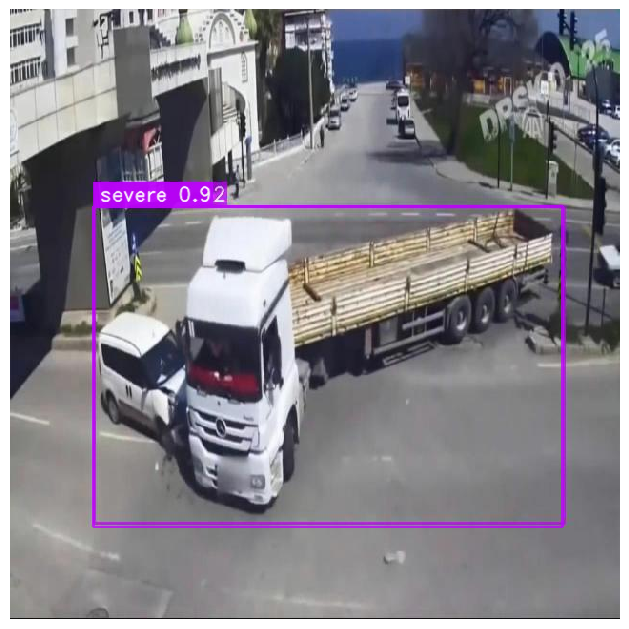

In [19]:
output_folder=r"/home/derin2/Desktop/Yolo/YOLONAS"

img_path = r"/home/derin2/Desktop/Yolo/YOLOv9/yolov9/AccidentsDetectionYOLOv8/test/images/14-169_jpg.rf.d0643d322e357551d96577a175cab081.jpg"
img_path2 = r"/home/derin2/Desktop/Yolo/YOLONAS/pred_0.jpg"

best_model.predict(img_path2, conf=0.50).show()